# Libraries import

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import mean_squared_error

d:\Jean-Baptiste\Documents\Columbia\Courses\IEOR4574\Code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Base functions definition
For importing, plotting and preprocessing the data

In [2]:
def open_data(print_head=False, columns=None):
    """
    Input :
    - print_head : boolean, if True print the head of the DataFrame
    - columns : list of string, if not None, return the DataFrame with only the columns in the list

    Output :
    - A Panda DataFrame with the data
    """
    data = pd.read_csv('Data\LD2011_2014.csv', parse_dates=['LD2011_2014'], index_col='LD2011_2014')
    data.rename(columns={'LD2011_2014': 'Timestamp'}, inplace=True)
    n=0
    for col in data.columns:
        if col != 'timestamp':
            data.rename(columns={col: f"EC_{n}"}, inplace=True)
            n+=1

    def convert_to_float(value):
        try:
            # Replace commas with points and convert to float
            return float(value.replace(',', '.'))
        except:
            # Handle any conversion errors (e.g., non-numeric values)
            return value

    # Apply the custom function to all values in the DataFrame
    data = data.applymap(convert_to_float)

    if columns:
        data = data[columns]

    if print_head:
        print(data.head())

    return data


def keep_important(df, threshold=365*1.5):
    """
    It removes the columns with more than threshold zeros (to avoid the columns with few data)

    Input :
    - df a Panda DataFrame

    Output :
    - A copy of the input without the
    """
    data = df.copy()
    nb = 0
    removed_col = []
    for k in data.columns:
        # Count the number of zeros
        a  = (data[k]==0).sum()
        if a > threshold :
            nb += 1
            # Remove column k
            removed_col.append(k)
            data = data.drop(k, axis=1)
    print('There are that many column who were removed :', nb)
    print(removed_col)
    return data

def plot_data(df, columns=None):
    """
    Plot the data of the DataFrame

    Input :
    - df : a Panda DataFrame
    - columns : list of string, if not None, plot only the columns in the list
    """
    if columns is None:
        columns = df.columns
    elif isinstance(columns, str):
        columns = [columns]
    elif isinstance(columns, int):
        columns = [df.columns[columns]]
    # Get the list of column names from the DataFrame
    df = df[columns]
    # Determine the number of rows and columns for subplots
    num_columns = len(columns)
    num_rows = (num_columns + 1) // 2  # Adjust this for your layout preference

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(30, num_rows * 4))
    fig.tight_layout(pad=4.0)  # Adjust the padding as needed

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.plot(df.index, df[column])
        ax.set_title(column)
        ax.set_xlabel('Date')  # You can customize the x-axis label
        ax.set_ylabel('Electricity_consumption')  # You can customize the y-axis label

    # Hide any unused subplots (if there are more subplots than columns)
    for j in range(i + 1, num_rows * 2):
        fig.delaxes(axes[j])

    plt.show()


def aggregate_data(df, freq='1H'):
    """ 
    Aggregate data to a specific frequency. frequency can be: '1H', '1D', '1W', '1M', '1Y'
    """
    return df.resample(freq).sum()

def calculate_mape(true_values, predictions):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between true values and predictions.

    Args:
    true_values (pd.Series or pd.DataFrame): Pandas Series or DataFrame containing the true values.
    predictions (pd.Series or pd.DataFrame): Pandas Series or DataFrame containing the predicted values.

    Returns:
    float or pd.Series: MAPE value(s).
    """
    # Ensure the input DataFrames have the same shape
    if true_values.shape != predictions.shape:
        raise ValueError("Input DataFrames must have the same shape")
    
    # reinitialize index
    true_values.reset_index(drop=True, inplace=True)
    predictions.reset_index(drop=True, inplace=True)
    # Calculate the absolute percentage error
    absolute_percentage_error = (np.abs(true_values - predictions))/true_values

    # Calculate the mean percentage error
    mape = absolute_percentage_error.mean()

    return mape

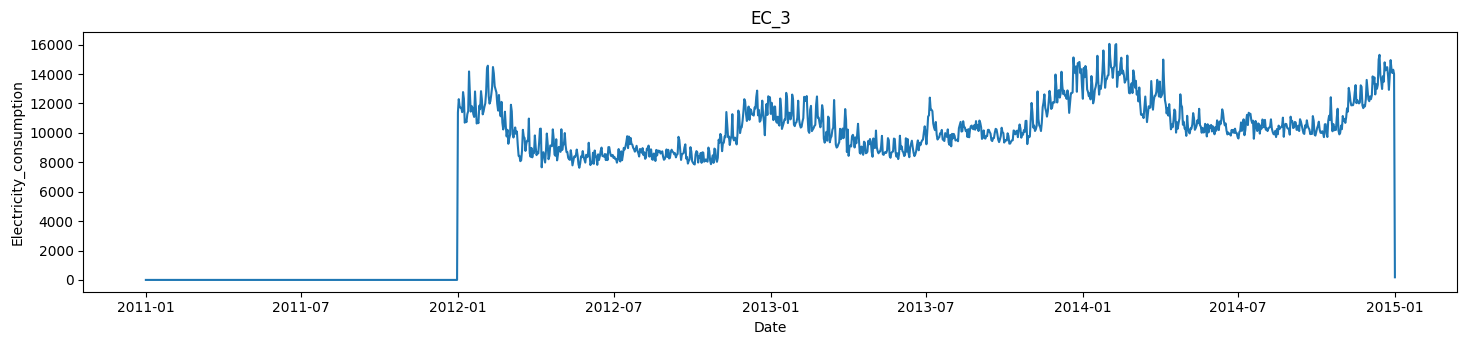

In [4]:
df_ini = open_data(columns=["EC_3"])
df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

# Prediction with Fb Prophet

## 1st basic model

In [5]:
predictor = Prophet()
df.reset_index(inplace=True) # necessary for prophet
df.columns = ['ds', 'y']    # necessary for prophet: it only works with these names
print(df.head())
print(df.tail())

          ds    y
0 2011-01-01  0.0
1 2011-01-02  0.0
2 2011-01-03  0.0
3 2011-01-04  0.0
4 2011-01-05  0.0
             ds             y
1457 2014-12-28  14327.235772
1458 2014-12-29  14067.073171
1459 2014-12-30  14290.650407
1460 2014-12-31  14006.097561
1461 2015-01-01    178.861789


In [6]:
predictor.fit(df)

11:19:25 - cmdstanpy - INFO - Chain [1] start processing
11:19:25 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = predictor.make_future_dataframe(periods=365, freq='D', include_history=False)
forecast = predictor.predict(future)
print(forecast.head())
print(forecast.tail())

          ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2015-01-02  12150.968130  12432.166732  15795.479917  12150.968130   
1 2015-01-03  12153.139510  13148.925382  16441.223231  12153.139510   
2 2015-01-04  12155.310891  12911.714757  16297.486857  12155.310891   
3 2015-01-05  12157.482271  12640.005707  15892.603950  12157.482271   
4 2015-01-06  12159.653652  12920.409290  16042.374588  12159.653652   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  12150.968130     1898.516235           1898.516235           1898.516235   
1  12153.139510     2656.041414           2656.041414           2656.041414   
2  12155.310891     2447.766915           2447.766915           2447.766915   
3  12157.482271     2209.423443           2209.423443           2209.423443   
4  12159.653652     2320.303873           2320.303873           2320.303873   

       weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0  -57.166151    -57

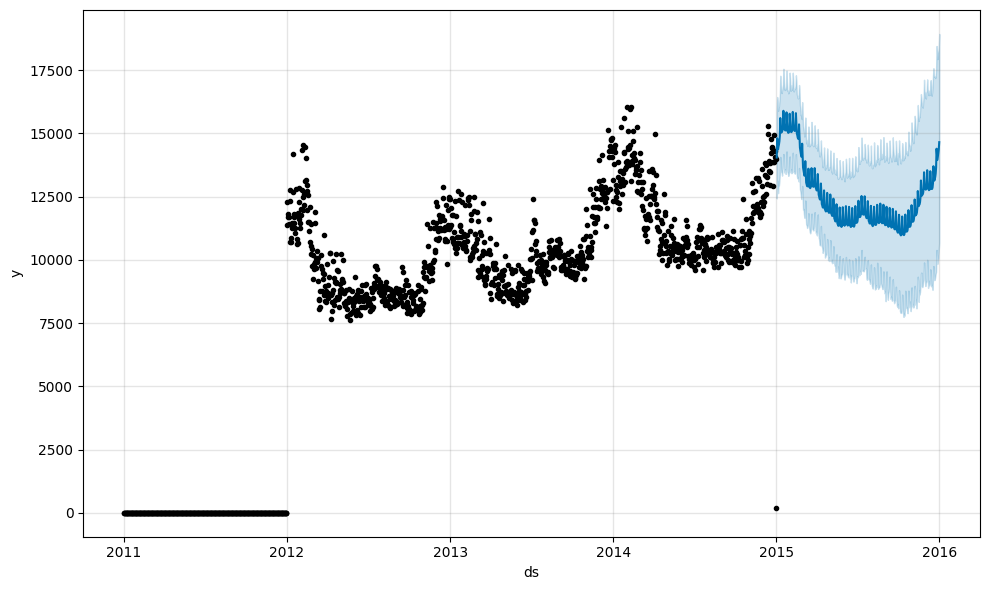

In [10]:
fig = predictor.plot(forecast)

## Rigorous approach to time series forecasting

We are going to use the following steps:
1. Split the data into train and test sets
2. Define the model
3. Fit the model to the training data
4. Make an out-of-sample forecast
5. Evaluate forecast accuracy
6. Plot the forecast

In [62]:
test_size = 31
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]
# remove the last row from the test set

In [63]:
predictor = Prophet()
predictor.fit(train_df)

16:37:12 - cmdstanpy - INFO - Chain [1] start processing
16:37:14 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = predictor.make_future_dataframe(periods=test_size, freq='D', include_history=False)
forecast = predictor.predict(future)


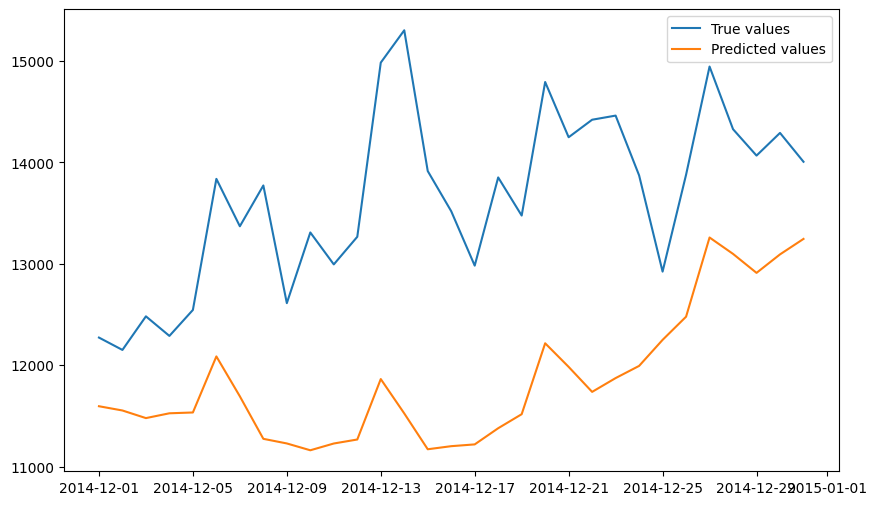

MAPE: 12.93%


In [65]:
# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='True values')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(test_df['y'], forecast['yhat'])
print(f"MAPE: {mape:.2%}")

## Different approach
We keep the whole data (we don't aggregate it, to see if training 15min per 15min can help)

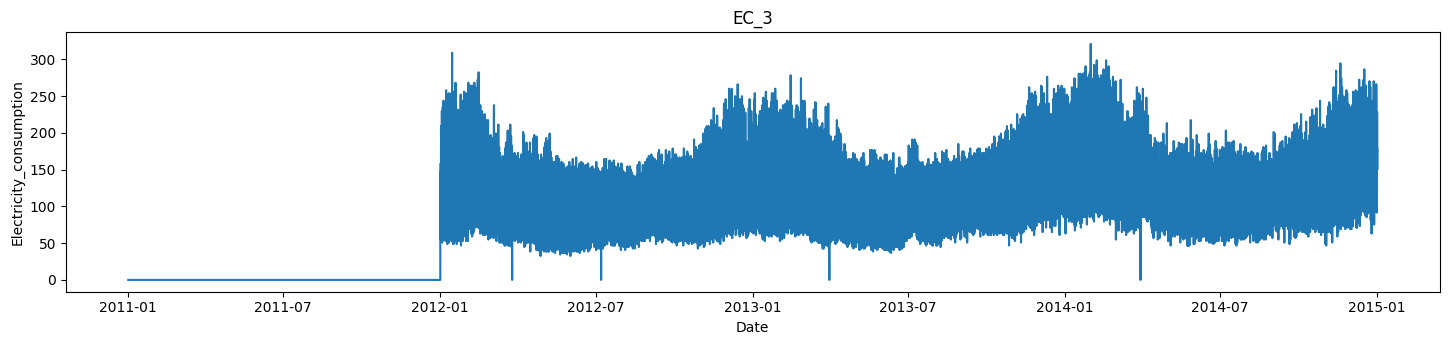

In [3]:
df_ini = open_data(columns=["EC_3"])
#df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

In [6]:
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
test_size = 31*4*24
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]
# remove the last row from the test set

In [7]:
predictor = Prophet()
predictor.fit(train_df)

19:13:12 - cmdstanpy - INFO - Chain [1] start processing
19:15:22 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
future = test_df[['ds']]
future.head()

ds
137279 2014-12-01 00:00:00
137280 2014-12-01 00:15:00
137281 2014-12-01 00:30:00
137282 2014-12-01 00:45:00
137283 2014-12-01 01:00:00

In [13]:
forecast = predictor.predict(future)

In [14]:
print(forecast.head())

                   ds       trend  yhat_lower  yhat_upper  trend_lower  \
0 2014-12-01 00:00:00  133.810391  110.944053  170.073524   133.810391   
1 2014-12-01 00:15:00  133.811322  109.413974  166.945508   133.811322   
2 2014-12-01 00:30:00  133.812252  103.404331  161.051294   133.812252   
3 2014-12-01 00:45:00  133.813183  101.242888  159.605804   133.813183   
4 2014-12-01 01:00:00  133.814114   97.990347  154.865189   133.814114   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   133.810391        6.167753              6.167753              6.167753   
1   133.811322        2.491936              2.491936              2.491936   
2   133.812252       -0.914941             -0.914941             -0.914941   
3   133.813183       -4.033455             -4.033455             -4.033455   
4   133.814114       -6.859261             -6.859261             -6.859261   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0  9.728933  ... -

Now we aggregate the data to 1 day, as we want to predict the consumption per day

In [15]:
daily_forecast = forecast.resample('D', on='ds').sum()
daily_truth = test_df.resample('D', on='ds').sum()

In [18]:
daily_forecast.reset_index(inplace=True)
daily_truth.reset_index(inplace=True)
print(daily_forecast.head())
print(daily_truth.head())

          ds         trend   yhat_lower    yhat_upper   trend_lower  \
0 2014-12-01  12850.042592  9667.025989  15221.612154  12850.042592   
1 2014-12-02  12858.622158  9784.973438  15348.817343  12858.622158   
2 2014-12-03  12867.201725  9669.968889  15210.268767  12867.201725   
3 2014-12-04  12875.781291  9771.441245  15327.842613  12875.781291   
4 2014-12-05  12884.360858  9792.684400  15377.823199  12884.360858   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  12850.042592     -401.678658           -401.678658           -401.678658   
1  12858.622158     -301.046711           -301.046711           -301.046711   
2  12867.201725     -422.642331           -422.642331           -422.642331   
3  12875.781291     -319.280055           -319.280055           -319.280055   
4  12884.360858     -302.937734           -302.937734           -302.937734   

          daily  ...      weekly  weekly_lower  weekly_upper      yearly  \
0 -7.306475e-10  ... -

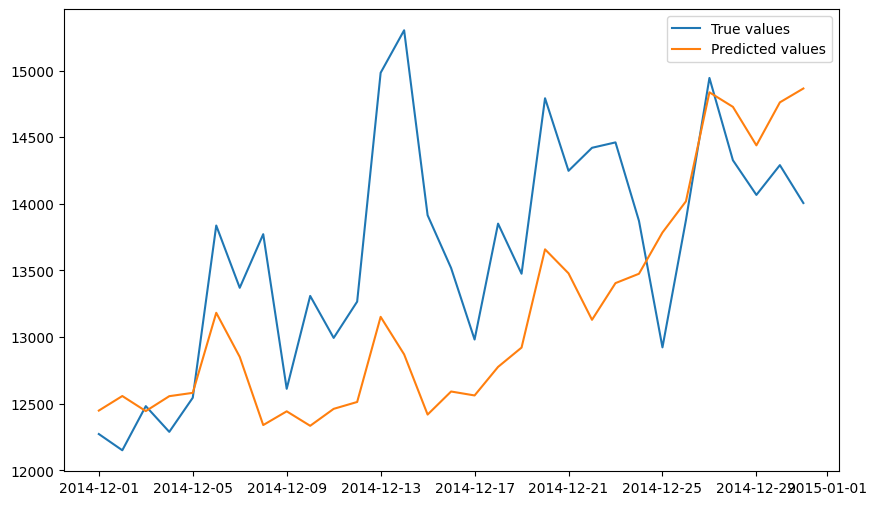

MAPE: 5.20%


In [19]:
# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(daily_truth['ds'], daily_truth['y'], label='True values')
plt.plot(daily_forecast['ds'], daily_forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(daily_truth['y'], daily_forecast['yhat'])
print(f"MAPE: {mape:.2%}")

## Include holidays
We know that the data comes from Portugal, so we will include the portuguese holidays, to see if it improves the model

In [11]:
# Holidays are in "Full_holidays.txt"
holidays = pd.read_csv('Data\Full_holidays.txt', sep='\t', header=None)
holidays['holidays'] = 1
holidays.columns = ['ds', 'holiday']
# convert the date column to datetime
holidays['ds'] = pd.to_datetime(holidays['ds'])
print(holidays.head())


          ds  holiday
0 2010-12-20        1
1 2010-12-21        1
2 2010-12-22        1
3 2010-12-23        1
4 2010-12-24        1


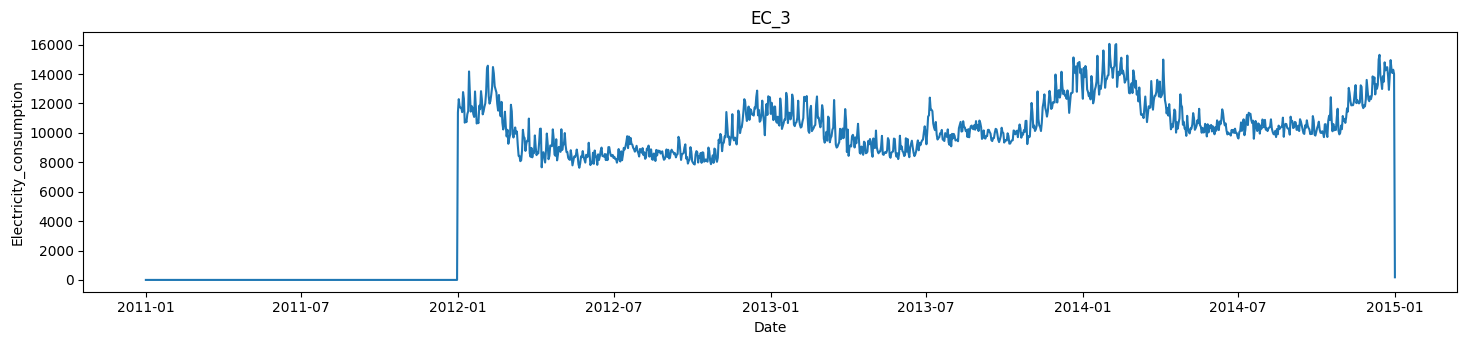

In [12]:
df_ini = open_data(columns=["EC_3"])
df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

In [13]:
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
test_size = 31
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

Here is how to proceed to get the data in the right format

In [25]:
holidays = pd.read_csv('Data\expanded_holidays.txt', sep='\t', header=None)
holidays[1] = 'Portuguese national holiday'
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays.rename(columns={0: 'ds', 1: 'holiday'}, inplace=True)
print(holidays.head())

           ds                      holiday  lower_window  upper_window
0  20.12.2010  Portuguese national holiday             0             1
1  21.12.2010  Portuguese national holiday             0             1
2  22.12.2010  Portuguese national holiday             0             1
3  23.12.2010  Portuguese national holiday             0             1
4  24.12.2010  Portuguese national holiday             0             1


In [26]:
predictor = Prophet(holidays=holidays)
predictor.fit(train_df)

18:45:56 - cmdstanpy - INFO - Chain [1] start processing
18:45:56 - cmdstanpy - INFO - Chain [1] done processing


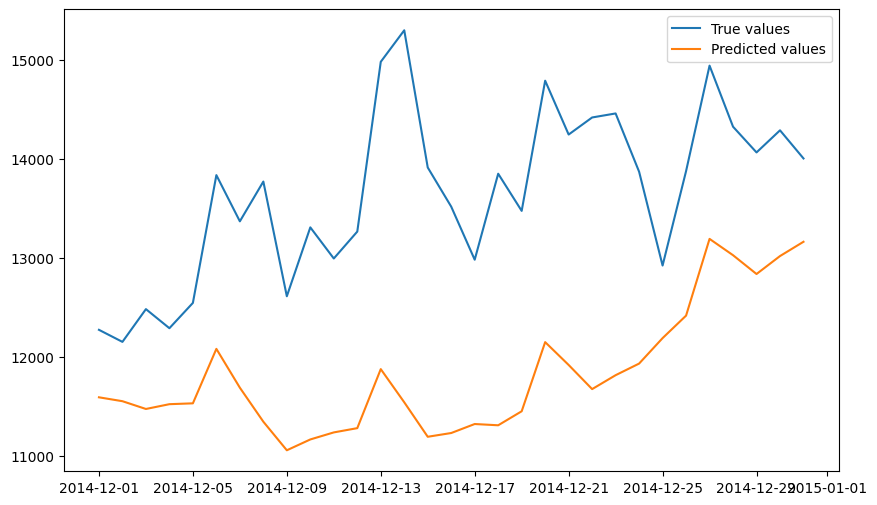

MAPE: 13.14%


In [27]:
future = predictor.make_future_dataframe(periods=test_size, freq='D', include_history=False)
forecast = predictor.predict(future)

# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='True values')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(test_df['y'], forecast['yhat'])
print(f"MAPE: {mape:.2%}")

In [31]:
forecast[forecast['Portuguese national holiday'] != 0]

ds         trend    yhat_lower    yhat_upper   trend_lower  \
7  2014-12-08  11710.107989   9916.431671  12803.739952  11710.107989   
8  2014-12-09  11710.694058   9578.003352  12480.438538  11710.694058   
16 2014-12-17  11715.382607   9920.965823  12718.286200  11704.451276   
17 2014-12-18  11715.968676   9788.546657  12750.069658  11703.379793   
18 2014-12-19  11716.554744  10033.806738  12943.824333  11702.718918   
19 2014-12-20  11717.140813  10810.450815  13537.296184  11701.385963   
20 2014-12-21  11717.726882  10545.003597  13319.256233  11699.161832   
21 2014-12-22  11718.312950  10229.611930  13123.064325  11696.209546   
22 2014-12-23  11718.899019  10439.289070  13265.778785  11694.172752   
23 2014-12-24  11719.485088  10562.181785  13260.721716  11690.966270   
24 2014-12-25  11720.071156  10710.532807  13616.914902  11688.690322   
25 2014-12-26  11720.657225  11010.914568  13832.222002  11687.392105   
26 2014-12-27  11721.243294  11813.625495  14690.547953  11682.570099   
27 2014-12-28  11721.829362  11610.567959  14637.497288  11678.094565   
28 2014-12-29  11722.415431  11432.594348  14286.092363  11673.723279   
29 2014-12-30  11723.001500  11601.767121  14378.507908  11671.026149   
30 2014-12-31  11723.587568  11841.650990  14569.418497  11669.397728   

     trend_upper  Portuguese national holiday  \
7   11710.107989                    72.617361   
8   11710.694058                  -177.010024   
16  11715.468403                    72.617361   
17  11718.038895                  -104.392663   
18  11719.248770                  -104.392663   
19  11722.355303                  -104.392663   
20  11727.289549                  -104.392663   
21  11731.562461                  -104.392663   
22  11735.663056                  -104.392663   
23  11739.172807                  -104.392663   
24  11742.217492                  -104.392663   
25  11745.607630                  -104.392663   
26  11747.502846                  -104.392663   
27  11750.289655                  -104.392663   
28  11755.729370                  -104.392663   
29  11760.722369                  -104.392663   
30  11767.069077                  -104.392663   

    Portuguese national holiday_lower  Portuguese national holiday_upper  \
7                           72.617361                          72.617361   
8                         -177.010024                        -177.010024   
16                          72.617361                          72.617361   
17                        -104.392663                        -104.392663   
18                        -104.392663                        -104.392663   
19                        -104.392663                        -104.392663   
20                        -104.392663                        -104.392663   
21                        -104.392663                        -104.392663   
22                        -104.392663                        -104.392663   
23                        -104.392663                        -104.392663   
24                        -104.392663                        -104.392663   
25                        -104.392663                        -104.392663   
26                        -104.392663                        -104.392663   
27                        -104.392663                        -104.392663   
28                        -104.392663                        -104.392663   
29                        -104.392663                        -104.392663   
30                        -104.392663                        -104.392663   

    additive_terms  ...      weekly  weekly_lower  weekly_upper       yearly  \
7      -367.324233  ... -176.140089   -176.140089   -176.140089  -263.801506   
8      -657.020669  ... -176.335478   -176.335478   -176.335478  -303.675166   
16     -396.061450  ... -211.242652   -211.242652   -211.242652  -257.436159   
17     -409.378446  ... -115.773977   -115.773977   -115.773977  -189.211806   
18     -268.241228  ...  -58.382884    -58.3

## Grid-search for fine tuning

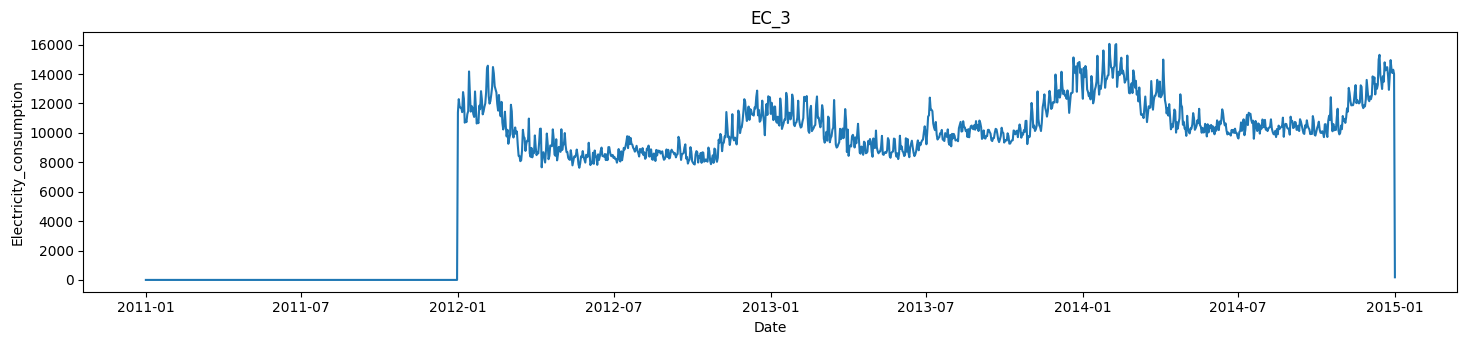

In [3]:
df_ini = open_data(columns=["EC_3"])
df_ini = aggregate_data(df_ini, freq='1D')
df_ini.dropna(inplace=True)
plot_data(df_ini, "EC_3")
df = df_ini.copy()

In [4]:
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
test_size = 31
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

In [32]:
from sklearn.model_selection import ParameterGrid


# Define the parameter grid for the grid search
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays': [None, holidays],  # 'holidays' should be your holiday dataframe
    'growth': ['linear'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
}

# Initialize the Prophet model
model = Prophet()

results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(train_df)

    # Make forecasts
    future = model.make_future_dataframe(periods=test_size, include_history=False)  # Adjust the forecasting window
    forecast = model.predict(future)

    # Calculate MAPE
    true_values = test_df['y']
    predicted_values = forecast['yhat']
    mape = calculate_mape(true_values, predicted_values)

    # Store the results
    results.append({
        'Parameters': params,
        'MAPE': mape,
    })

# Find the best set of parameters based on MAPE
best_result = min(results, key=lambda x: x['MAPE'])
print("Best Parameters:", best_result['Parameters'])
print("Best MAPE:", best_result['MAPE'])


18:49:44 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing
18:49:45 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing
18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:46 - cmdstanpy - INFO - Chain [1] done processing
18:49:47 - cmdstanpy - INFO - Chain [1] start processing
18:49:47 - cmdstanpy - INFO - Chain [1] done processing
18:49:48 - cmdstanpy - INFO - Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing
18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing
18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing
18:49:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'seasonality_mode': 'multipli

18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing


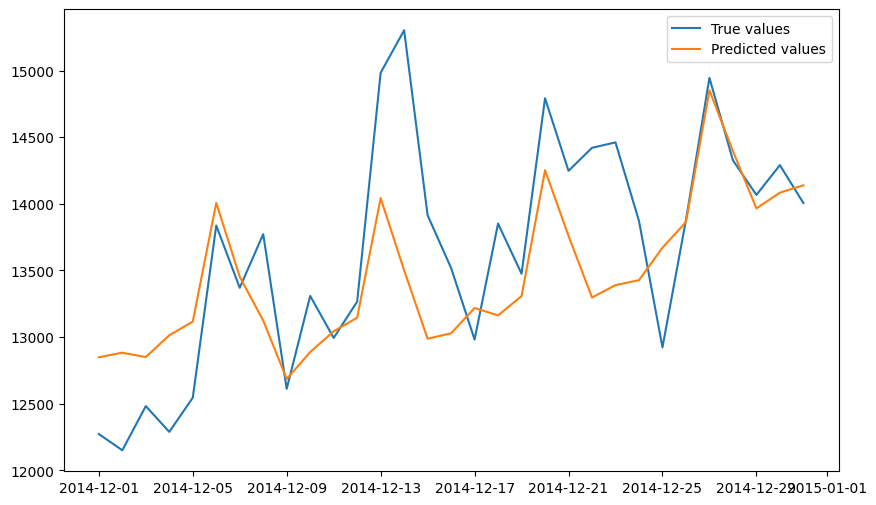

MAPE: 3.4745%


In [33]:
# Now train the model with the best set of parameters, plot the results, and calculate the MAPE
model = Prophet(**best_result['Parameters'])
model.fit(train_df)

future = model.make_future_dataframe(periods=test_size, include_history=False)
forecast = model.predict(future)

# Plot the true value VS the predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='True values')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted values')
plt.legend()
plt.show()

# Calculate the MAPE
mape = calculate_mape(test_df['y'], forecast['yhat'])
print(f"MAPE: {mape:.4%}")

### Best parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'multiplicative'}

# Prediction with Fb Prophet for all time series

the goal is to compute the average MAPE for all time series, by training a model for each one of them. (A model cannot be used to predict for sereval time series).

We are going to use the best parameters found in the previous section.

In [3]:
full_df_ini = open_data()
full_df = full_df_ini.copy()


In [4]:
holidays = pd.read_csv('Data\expanded_holidays.txt', sep='\t', header=None)
holidays[1] = 'Portuguese national holiday'
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays.rename(columns={0: 'ds', 1: 'holiday'}, inplace=True)
print(holidays.head())

           ds                      holiday  lower_window  upper_window
0  20.12.2010  Portuguese national holiday             0             1
1  21.12.2010  Portuguese national holiday             0             1
2  22.12.2010  Portuguese national holiday             0             1
3  23.12.2010  Portuguese national holiday             0             1
4  24.12.2010  Portuguese national holiday             0             1


## Overall fine tuning

In [15]:
full_df = aggregate_data(full_df, freq='1D')
full_df = keep_important(full_df, 365*1.01)
columns = full_df.columns
print("There are", len(columns), "columns in the dataset")

best_params = {'seasonality_mode': 'multiplicative', 
               'holidays': holidays, 
               'growth': 'linear', 
               'changepoint_prior_scale': 0.05
               }
mape_results = {}
test_size = 31

There are that many column who were removed : 0
[]
There are 318 columns in the dataset


In [6]:
#Fine tuning over all columns
from sklearn.model_selection import ParameterGrid

# Load and prepare your dataset
# Replace 'your_dataframe' with your actual DataFrame
# Ensure your DataFrame has 'ds' and 'y' columns

# Define the parameter grid for the grid search
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'holidays': [None, holidays],  # 'holidays' should be your holiday dataframe
    'growth': ['linear'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
}

score = {}
for i, parameters in enumerate(ParameterGrid(param_grid)):
    print("Iteration {} - Parameters: {}".format(i, parameters))
    score[i] = 0
    for column in columns:
        
        df = full_df[[column]].copy()
        df.reset_index(inplace=True)
        df.columns = ['ds', 'y']
        train_df = df[:-test_size-1]
        test_df = df[-test_size-1:-1]

        model = Prophet(**parameters, uncertainty_samples=False)
        model.fit(train_df)

        future = test_df[['ds']]
        forecast = model.predict(future)

        """daily_forecast = forecast.resample('D', on='ds').sum()
        daily_truth = test_df.resample('D', on='ds').sum()

        daily_forecast.reset_index(inplace=True)
        daily_truth.reset_index(inplace=True)"""

        daily_forecast = forecast
        daily_truth = test_df

        daily_forecast.reset_index(inplace=True)
        daily_truth.reset_index(inplace=True)
        
        # Calculate the MAPE
        mape = calculate_mape(daily_truth['y'], daily_forecast['yhat'])
        mape_results.append(mape)
        if mape != float('inf'):
            score[i]+=mape
        #print("Iteration {} - MAPE: {:.4%}".format(column, mape))


print("Done!")

Iteration 0 - Parameters: {'changepoint_prior_scale': 0.01, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'additive'}


17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1]

Iteration 1 - Parameters: {'changepoint_prior_scale': 0.01, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'multiplicative'}


17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:52 - cmdstanpy - INFO - Chain [1] done processing
17:39:52 - cmdstanpy - INFO - Chain [1] start processing
17:39:52 - cmdstanpy - INFO - Chain [1] done processing
17:39:52 - cmdstanpy - INFO - Chain [1] start processing
17:39:52 - cmdstanpy - INFO - Chain [1] done processing
17:39:53 - cmdstanpy - INFO - Chain [1] start processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
17:39:53 - cmdstanpy - INFO - Chain [1] start processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
17:39:53 - cmdstanpy - INFO - Chain [1] start processing
17:39:53 - cmdstanpy - INFO - Chain [1] done processing
17:39:54 - cmdstanpy - INFO - Chain [1] start processing
17:39:54 - cmdstanpy - INFO - Chain [1] done processing
17:39:54 - cmdstanpy - INFO - Chain [1] start processing
17:39:54 - cmdstanpy - INFO - Chain [1] done processing
17:39:54 - cmdstanpy - INFO - Chain [1] start processing
17:39:54 - cmdstanpy - INFO - Chain [1]

Iteration 2 - Parameters: {'changepoint_prior_scale': 0.01, 'growth': 'linear', 'holidays':              ds                      holiday  lower_window  upper_window
0    20.12.2010  Portuguese national holiday             0             1
1    21.12.2010  Portuguese national holiday             0             1
2    22.12.2010  Portuguese national holiday             0             1
3    23.12.2010  Portuguese national holiday             0             1
4    24.12.2010  Portuguese national holiday             0             1
..          ...                          ...           ...           ...
680  01.05.2015  Portuguese national holiday             0             1
681  10.06.2015  Portuguese national holiday             0             1
682  15.08.2015  Portuguese national holiday             0             1
683  08.12.2015  Portuguese national holiday             0             1
684  25.12.2015  Portuguese national holiday             0             1

[685 rows x 4 columns], 'season

17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing
17:41:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1]

Iteration 3 - Parameters: {'changepoint_prior_scale': 0.01, 'growth': 'linear', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'seasonality_mode':

17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:54 - cmdstanpy - INFO - Chain [1] start processing
17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:56 - cmdstanpy - INFO - Chain [1] done processing
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1]

Iteration 4 - Parameters: {'changepoint_prior_scale': 0.05, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'additive'}


17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:57 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:58 - cmdstanpy - INFO - Chain [1] start processing
17:47:58 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:59 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] 

Iteration 5 - Parameters: {'changepoint_prior_scale': 0.05, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'multiplicative'}


17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:14 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:17 - cmdstanpy - INFO - Chain [1]

Iteration 6 - Parameters: {'changepoint_prior_scale': 0.05, 'growth': 'linear', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'seasonality_mode':

17:52:35 - cmdstanpy - INFO - Chain [1] start processing
17:52:35 - cmdstanpy - INFO - Chain [1] done processing
17:52:36 - cmdstanpy - INFO - Chain [1] start processing
17:52:36 - cmdstanpy - INFO - Chain [1] done processing
17:52:36 - cmdstanpy - INFO - Chain [1] start processing
17:52:37 - cmdstanpy - INFO - Chain [1] done processing
17:52:37 - cmdstanpy - INFO - Chain [1] start processing
17:52:37 - cmdstanpy - INFO - Chain [1] done processing
17:52:38 - cmdstanpy - INFO - Chain [1] start processing
17:52:38 - cmdstanpy - INFO - Chain [1] done processing
17:52:39 - cmdstanpy - INFO - Chain [1] start processing
17:52:39 - cmdstanpy - INFO - Chain [1] done processing
17:52:39 - cmdstanpy - INFO - Chain [1] start processing
17:52:39 - cmdstanpy - INFO - Chain [1] done processing
17:52:40 - cmdstanpy - INFO - Chain [1] start processing
17:52:40 - cmdstanpy - INFO - Chain [1] done processing
17:52:41 - cmdstanpy - INFO - Chain [1] start processing
17:52:41 - cmdstanpy - INFO - Chain [1]

Iteration 7 - Parameters: {'changepoint_prior_scale': 0.05, 'growth': 'linear', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'seasonality_mode':

17:56:11 - cmdstanpy - INFO - Chain [1] start processing
17:56:11 - cmdstanpy - INFO - Chain [1] done processing
17:56:11 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing
17:56:12 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:13 - cmdstanpy - INFO - Chain [1] done processing
17:56:13 - cmdstanpy - INFO - Chain [1] start processing
17:56:14 - cmdstanpy - INFO - Chain [1] done processing
17:56:14 - cmdstanpy - INFO - Chain [1] start processing
17:56:14 - cmdstanpy - INFO - Chain [1] done processing
17:56:15 - cmdstanpy - INFO - Chain [1] start processing
17:56:15 - cmdstanpy - INFO - Chain [1] done processing
17:56:15 - cmdstanpy - INFO - Chain [1] start processing
17:56:15 - cmdstanpy - INFO - Chain [1] done processing
17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:16 - cmdstanpy - INFO - Chain [1]

Iteration 8 - Parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'additive'}


17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:50 - cmdstanpy - INFO - Chain [1] start processing
17:59:50 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:51 - cmdstanpy - INFO - Chain [1] start processing
17:59:51 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:52 - cmdstanpy - INFO - Chain [1] done processing
17:59:52 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:53 - cmdstanpy - INFO - Chain [1] done processing
17:59:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:54 - cmdstanpy - INFO - Chain [1] done processing
17:59:55 - cmdstanpy - INFO - Chain [1] 

Iteration 9 - Parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays': None, 'seasonality_mode': 'multiplicative'}


18:02:40 - cmdstanpy - INFO - Chain [1] start processing
18:02:40 - cmdstanpy - INFO - Chain [1] done processing
18:02:40 - cmdstanpy - INFO - Chain [1] start processing
18:02:40 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:41 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
18:02:43 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
18:02:43 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:44 - cmdstanpy - INFO - Chain [1]

Iteration 10 - Parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'seasonality_mode':

18:05:25 - cmdstanpy - INFO - Chain [1] start processing
18:05:26 - cmdstanpy - INFO - Chain [1] done processing
18:05:26 - cmdstanpy - INFO - Chain [1] start processing
18:05:27 - cmdstanpy - INFO - Chain [1] done processing
18:05:27 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:28 - cmdstanpy - INFO - Chain [1] done processing
18:05:29 - cmdstanpy - INFO - Chain [1] start processing
18:05:29 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing
18:05:30 - cmdstanpy - INFO - Chain [1] start processing
18:05:31 - cmdstanpy - INFO - Chain [1] done processing
18:05:31 - cmdstanpy - INFO - Chain [1] start processing
18:05:32 - cmdstanpy - INFO - Chain [1] done processing
18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:05:33 - cmdstanpy - INFO - Chain [1]

Iteration 11 - Parameters: {'changepoint_prior_scale': 0.1, 'growth': 'linear', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'seasonality_mode':

18:09:32 - cmdstanpy - INFO - Chain [1] start processing
18:09:32 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing
18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:37 - cmdstanpy - INFO - Chain [1] done processing
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1]

Done!


Total score for each parameter set:

In [ ]:
print(score)

In [8]:
print(ParameterGrid(param_grid)[7])

{'seasonality_mode': 'multiplicative', 'holidays':             ds                      holiday  lower_window  upper_window
0   2010-12-20  Portuguese national holiday             0             1
1   2010-12-21  Portuguese national holiday             0             1
2   2010-12-22  Portuguese national holiday             0             1
3   2010-12-23  Portuguese national holiday             0             1
4   2010-12-24  Portuguese national holiday             0             1
..         ...                          ...           ...           ...
680 2015-05-01  Portuguese national holiday             0             1
681 2015-06-10  Portuguese national holiday             0             1
682 2015-08-15  Portuguese national holiday             0             1
683 2015-12-08  Portuguese national holiday             0             1
684 2015-12-25  Portuguese national holiday             0             1

[685 rows x 4 columns], 'growth': 'linear', 'changepoint_prior_scale': 0.05}


In [ ]:
{'seasonality_mode': 'multiplicative', 'holidays': holidays, 'growth': 'linear', 'changepoint_prior_scale': 0.05}

In [16]:
# Iterate over all columns

for column in columns:
    df = full_df[[column]].copy()
    df.reset_index(inplace=True)
    df.columns = ['ds', 'y']
    train_df = df[:-test_size-1]
    test_df = df[-test_size-1:-1]

    model = Prophet(**best_params, uncertainty_samples=False)
    model.fit(train_df)

    future = test_df[['ds']]
    forecast = model.predict(future)

    """daily_forecast = forecast.resample('D', on='ds').sum()
    daily_truth = test_df.resample('D', on='ds').sum()

    daily_forecast.reset_index(inplace=True)
    daily_truth.reset_index(inplace=True)"""

    daily_forecast = forecast
    daily_truth = test_df

    daily_forecast.reset_index(inplace=True)
    daily_truth.reset_index(inplace=True)
    
    # Calculate the MAPE
    mape = calculate_mape(daily_truth['y'], daily_forecast['yhat'])
    mape_results[column]=mape

    print("Iteration {} - MAPE: {:.4%}".format(column, mape))


print("Done!")

18:39:24 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_0 - MAPE: 64.1981%


18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_1 - MAPE: 5.2203%


18:39:26 - cmdstanpy - INFO - Chain [1] start processing
18:39:26 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_2 - MAPE: 547.3704%


18:39:27 - cmdstanpy - INFO - Chain [1] start processing
18:39:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_3 - MAPE: 3.9389%


18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:28 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_4 - MAPE: 11.6676%


18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_5 - MAPE: 9.3102%


18:39:30 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_6 - MAPE: 42.9885%


18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_7 - MAPE: 11.0063%


18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_8 - MAPE: 10.7766%


18:39:32 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_9 - MAPE: 12.6045%


18:39:33 - cmdstanpy - INFO - Chain [1] start processing
18:39:34 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_10 - MAPE: 10.3745%


18:39:34 - cmdstanpy - INFO - Chain [1] start processing
18:39:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_12 - MAPE: 34.0276%


18:39:35 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_13 - MAPE: 10.0885%


18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:37 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_15 - MAPE: 9.1601%


18:39:37 - cmdstanpy - INFO - Chain [1] start processing
18:39:38 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_16 - MAPE: 4.7630%


18:39:38 - cmdstanpy - INFO - Chain [1] start processing
18:39:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_17 - MAPE: 8.6070%


18:39:39 - cmdstanpy - INFO - Chain [1] start processing
18:39:40 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_18 - MAPE: 9.9443%


18:39:40 - cmdstanpy - INFO - Chain [1] start processing
18:39:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_19 - MAPE: 10.5776%


18:39:41 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_20 - MAPE: 5.6221%


18:39:42 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_21 - MAPE: 13.7331%


18:39:43 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_22 - MAPE: 268.8159%


18:39:44 - cmdstanpy - INFO - Chain [1] start processing
18:39:44 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_24 - MAPE: 8.8207%


18:39:45 - cmdstanpy - INFO - Chain [1] start processing
18:39:45 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_25 - MAPE: 7.5341%


18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_26 - MAPE: 6.4257%


18:39:47 - cmdstanpy - INFO - Chain [1] start processing
18:39:47 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_27 - MAPE: 9.1530%


18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_28 - MAPE: 24.8928%


18:39:49 - cmdstanpy - INFO - Chain [1] start processing
18:39:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_30 - MAPE: 8.5795%


18:39:50 - cmdstanpy - INFO - Chain [1] start processing
18:39:50 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_33 - MAPE: 15.6234%


18:39:51 - cmdstanpy - INFO - Chain [1] start processing
18:39:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_34 - MAPE: 8.9979%


18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_35 - MAPE: 59.3752%


18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_36 - MAPE: 11.7926%


18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_37 - MAPE: 8.6050%


18:39:54 - cmdstanpy - INFO - Chain [1] start processing
18:39:55 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_39 - MAPE: 8.3807%


18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_41 - MAPE: 6.1964%


18:39:56 - cmdstanpy - INFO - Chain [1] start processing
18:39:57 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_42 - MAPE: 3.9579%


18:39:57 - cmdstanpy - INFO - Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_43 - MAPE: 8.7692%


18:39:58 - cmdstanpy - INFO - Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_44 - MAPE: 26.8585%


18:39:59 - cmdstanpy - INFO - Chain [1] start processing
18:39:59 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_45 - MAPE: 6.4390%


18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_46 - MAPE: 8.0751%


18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:01 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_47 - MAPE: 10.5376%


18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_48 - MAPE: 5.1778%


18:40:03 - cmdstanpy - INFO - Chain [1] start processing
18:40:03 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_49 - MAPE: 15.2260%


18:40:04 - cmdstanpy - INFO - Chain [1] start processing
18:40:04 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_50 - MAPE: 8.8743%


18:40:04 - cmdstanpy - INFO - Chain [1] start processing
18:40:05 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_51 - MAPE: 5.6791%


18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_52 - MAPE: 8.4568%


18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_53 - MAPE: 5.3211%


18:40:08 - cmdstanpy - INFO - Chain [1] start processing
18:40:08 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_54 - MAPE: 11.6373%


18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_55 - MAPE: 11.2396%


18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_56 - MAPE: 518.1639%


18:40:10 - cmdstanpy - INFO - Chain [1] start processing
18:40:11 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_57 - MAPE: 10.3251%


18:40:11 - cmdstanpy - INFO - Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_58 - MAPE: 8.8427%


18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_59 - MAPE: 9.8603%


18:40:13 - cmdstanpy - INFO - Chain [1] start processing
18:40:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_60 - MAPE: 7.6699%


18:40:14 - cmdstanpy - INFO - Chain [1] start processing
18:40:14 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_61 - MAPE: 10.3741%


18:40:15 - cmdstanpy - INFO - Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_62 - MAPE: 8.8983%


18:40:16 - cmdstanpy - INFO - Chain [1] start processing
18:40:16 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_63 - MAPE: 313.2808%


18:40:17 - cmdstanpy - INFO - Chain [1] start processing
18:40:17 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_64 - MAPE: 7.4951%


18:40:18 - cmdstanpy - INFO - Chain [1] start processing
18:40:18 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_65 - MAPE: 10.2721%


18:40:19 - cmdstanpy - INFO - Chain [1] start processing
18:40:19 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_66 - MAPE: 7.5841%


18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:20 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_67 - MAPE: 20.0616%


18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:21 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_68 - MAPE: 6.2038%


18:40:22 - cmdstanpy - INFO - Chain [1] start processing
18:40:22 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_69 - MAPE: 5.4533%


18:40:23 - cmdstanpy - INFO - Chain [1] start processing
18:40:23 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_70 - MAPE: 6.6782%


18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_71 - MAPE: 8.0983%


18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_72 - MAPE: 12.9081%


18:40:26 - cmdstanpy - INFO - Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_73 - MAPE: 8.8227%


18:40:26 - cmdstanpy - INFO - Chain [1] start processing
18:40:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_74 - MAPE: 12.1271%


18:40:27 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_75 - MAPE: 5.3008%


18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_76 - MAPE: 14.6084%


18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_77 - MAPE: 12.1080%


18:40:30 - cmdstanpy - INFO - Chain [1] start processing
18:40:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_78 - MAPE: 17.1213%


18:40:31 - cmdstanpy - INFO - Chain [1] start processing
18:40:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_79 - MAPE: 7.6144%


18:40:32 - cmdstanpy - INFO - Chain [1] start processing
18:40:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_80 - MAPE: 7.3210%


18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:40:34 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_81 - MAPE: 4.0200%


18:40:34 - cmdstanpy - INFO - Chain [1] start processing
18:40:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_82 - MAPE: 6.5027%


18:40:35 - cmdstanpy - INFO - Chain [1] start processing
18:40:36 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_83 - MAPE: 12.4639%


18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:37 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_84 - MAPE: 6.5694%


18:40:37 - cmdstanpy - INFO - Chain [1] start processing
18:40:38 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_85 - MAPE: 11.8808%


18:40:38 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_86 - MAPE: 17.9533%


18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_87 - MAPE: 15.2655%


18:40:40 - cmdstanpy - INFO - Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_88 - MAPE: 9.0759%


18:40:41 - cmdstanpy - INFO - Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_89 - MAPE: 217.2056%


18:40:42 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_90 - MAPE: 15.8908%


18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_92 - MAPE: 433.6643%


18:40:44 - cmdstanpy - INFO - Chain [1] start processing
18:40:44 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_93 - MAPE: 43.3835%


18:40:45 - cmdstanpy - INFO - Chain [1] start processing
18:40:45 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_94 - MAPE: 35.0770%


18:40:46 - cmdstanpy - INFO - Chain [1] start processing
18:40:46 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_95 - MAPE: 18.4237%


18:40:47 - cmdstanpy - INFO - Chain [1] start processing
18:40:47 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_96 - MAPE: 22.1455%


18:40:47 - cmdstanpy - INFO - Chain [1] start processing
18:40:48 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_97 - MAPE: 5.3924%


18:40:49 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_98 - MAPE: 9.8615%


18:40:50 - cmdstanpy - INFO - Chain [1] start processing
18:40:50 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_99 - MAPE: 18.8706%


18:40:51 - cmdstanpy - INFO - Chain [1] start processing
18:40:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_100 - MAPE: 16.3585%


18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:52 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_101 - MAPE: 5.8028%


18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_102 - MAPE: 12.8130%


18:40:54 - cmdstanpy - INFO - Chain [1] start processing
18:40:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_103 - MAPE: 18.2897%


18:40:55 - cmdstanpy - INFO - Chain [1] start processing
18:40:55 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_104 - MAPE: 21.8327%


18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_113 - MAPE: 13.0574%


18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_117 - MAPE: 10.1043%


18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_118 - MAPE: 10.7082%


18:40:59 - cmdstanpy - INFO - Chain [1] start processing
18:40:59 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_122 - MAPE: 375.3432%


18:41:00 - cmdstanpy - INFO - Chain [1] start processing
18:41:00 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_123 - MAPE: 15.9380%


18:41:01 - cmdstanpy - INFO - Chain [1] start processing
18:41:01 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_124 - MAPE: 22.1424%


18:41:02 - cmdstanpy - INFO - Chain [1] start processing
18:41:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_125 - MAPE: 19.0152%


18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:03 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_127 - MAPE: 37.4794%


18:41:04 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_128 - MAPE: 6.6387%


18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:06 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_129 - MAPE: 28.1712%


18:41:06 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_130 - MAPE: 56.8024%


18:41:07 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_131 - MAPE: 27.8079%


18:41:08 - cmdstanpy - INFO - Chain [1] start processing
18:41:08 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_134 - MAPE: 10.6680%


18:41:09 - cmdstanpy - INFO - Chain [1] start processing
18:41:09 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_135 - MAPE: 918.0198%


18:41:10 - cmdstanpy - INFO - Chain [1] start processing
18:41:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_136 - MAPE: 10.6010%


18:41:11 - cmdstanpy - INFO - Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_137 - MAPE: 13.6506%


18:41:12 - cmdstanpy - INFO - Chain [1] start processing
18:41:12 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_138 - MAPE: 12.4445%


18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_139 - MAPE: 38.2047%


18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_140 - MAPE: 34.7074%


18:41:14 - cmdstanpy - INFO - Chain [1] start processing
18:41:14 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_141 - MAPE: 11.8183%


18:41:15 - cmdstanpy - INFO - Chain [1] start processing
18:41:16 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_142 - MAPE: 750.4817%


18:41:16 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_144 - MAPE: 4.1208%


18:41:17 - cmdstanpy - INFO - Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_146 - MAPE: 4.1402%


18:41:18 - cmdstanpy - INFO - Chain [1] start processing
18:41:19 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_147 - MAPE: 11.5324%


18:41:19 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_148 - MAPE: 16.2133%


18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_149 - MAPE: 6.1875%


18:41:21 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_150 - MAPE: 549.8083%


18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_152 - MAPE: 10.8058%


18:41:23 - cmdstanpy - INFO - Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_153 - MAPE: 14.2584%


18:41:24 - cmdstanpy - INFO - Chain [1] start processing
18:41:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_154 - MAPE: 23.4345%


18:41:25 - cmdstanpy - INFO - Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_155 - MAPE: 13.6835%


18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_156 - MAPE: 11.4760%


18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_157 - MAPE: 12.1777%


18:41:28 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_158 - MAPE: 45.2233%


18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_160 - MAPE: 3.3495%


18:41:30 - cmdstanpy - INFO - Chain [1] start processing
18:41:30 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_161 - MAPE: 26.1073%


18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_162 - MAPE: 10.7271%


18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_163 - MAPE: 20.4382%


18:41:32 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_165 - MAPE: 5.9867%


18:41:33 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_167 - MAPE: 8.3194%


18:41:34 - cmdstanpy - INFO - Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_168 - MAPE: 7.5987%


18:41:35 - cmdstanpy - INFO - Chain [1] start processing
18:41:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_170 - MAPE: 7.8309%


18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_171 - MAPE: 8.3171%


18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_173 - MAPE: 512.3349%


18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_174 - MAPE: 628.2497%


18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_175 - MAPE: 4.8621%


18:41:39 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_179 - MAPE: 17.3402%


18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_181 - MAPE: 4.9799%


18:41:41 - cmdstanpy - INFO - Chain [1] start processing
18:41:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_182 - MAPE: 8.3636%


18:41:42 - cmdstanpy - INFO - Chain [1] start processing
18:41:42 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_186 - MAPE: 10.8924%


18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_187 - MAPE: 506.0744%


18:41:44 - cmdstanpy - INFO - Chain [1] start processing
18:41:44 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_188 - MAPE: 8.7775%


18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_189 - MAPE: 10.5038%


18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_190 - MAPE: 8.3459%


18:41:46 - cmdstanpy - INFO - Chain [1] start processing
18:41:46 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_191 - MAPE: 10.1368%


18:41:47 - cmdstanpy - INFO - Chain [1] start processing
18:41:47 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_192 - MAPE: 4.9237%


18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:48 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_193 - MAPE: 12.6213%


18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_194 - MAPE: 9.4384%


18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_195 - MAPE: 4.9993%


18:41:50 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_196 - MAPE: 6.5158%


18:41:51 - cmdstanpy - INFO - Chain [1] start processing
18:41:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_197 - MAPE: 15.8093%


18:41:52 - cmdstanpy - INFO - Chain [1] start processing
18:41:52 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_198 - MAPE: 7.6227%


18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_199 - MAPE: 10.9522%


18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_200 - MAPE: 6.9083%


18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_201 - MAPE: 5.6286%


18:41:55 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_202 - MAPE: 109.6711%


18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_203 - MAPE: 10.0422%


18:41:57 - cmdstanpy - INFO - Chain [1] start processing
18:41:57 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_204 - MAPE: 474.8623%


18:41:57 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_205 - MAPE: 10.4622%


18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_206 - MAPE: 8.5064%


18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:41:59 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_207 - MAPE: 7.5980%


18:42:00 - cmdstanpy - INFO - Chain [1] start processing
18:42:00 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_208 - MAPE: 13.7596%


18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:01 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_209 - MAPE: 7.8960%


18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_210 - MAPE: 9.9289%


18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_211 - MAPE: 8.0378%


18:42:03 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_212 - MAPE: 10.9704%


18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:04 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_213 - MAPE: 6.8794%


18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_214 - MAPE: 3.6131%


18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_215 - MAPE: 7.5756%


18:42:06 - cmdstanpy - INFO - Chain [1] start processing
18:42:06 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_216 - MAPE: 7.8651%


18:42:07 - cmdstanpy - INFO - Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_217 - MAPE: 6.5847%


18:42:08 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_218 - MAPE: 9.0013%


18:42:09 - cmdstanpy - INFO - Chain [1] start processing
18:42:09 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_219 - MAPE: 8.9142%


18:42:09 - cmdstanpy - INFO - Chain [1] start processing
18:42:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_220 - MAPE: 5.7315%


18:42:10 - cmdstanpy - INFO - Chain [1] start processing
18:42:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_221 - MAPE: 6.5186%


18:42:11 - cmdstanpy - INFO - Chain [1] start processing
18:42:11 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_224 - MAPE: 4.6343%


18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:12 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_225 - MAPE: 11.3050%


18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_226 - MAPE: 7.8452%


18:42:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_227 - MAPE: 7.4400%


18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_228 - MAPE: 276.7207%


18:42:15 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_229 - MAPE: 8.0705%


18:42:16 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_230 - MAPE: 14.0487%


18:42:16 - cmdstanpy - INFO - Chain [1] start processing
18:42:16 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_231 - MAPE: 9.5985%


18:42:17 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_232 - MAPE: 8.3606%


18:42:18 - cmdstanpy - INFO - Chain [1] start processing
18:42:18 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_233 - MAPE: 7.2085%


18:42:19 - cmdstanpy - INFO - Chain [1] start processing
18:42:19 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_234 - MAPE: 13.4142%


18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:20 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_235 - MAPE: 453.3424%


18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_236 - MAPE: 9.1293%


18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_237 - MAPE: 5.2408%


18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_238 - MAPE: 7.7490%


18:42:23 - cmdstanpy - INFO - Chain [1] start processing
18:42:23 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_239 - MAPE: 7.4214%


18:42:23 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_240 - MAPE: 14.3678%


18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_241 - MAPE: 6.8582%


18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_242 - MAPE: 6.9277%


18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_243 - MAPE: 4.6519%


18:42:26 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_244 - MAPE: 5.9818%


18:42:27 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_245 - MAPE: 587.6011%


18:42:28 - cmdstanpy - INFO - Chain [1] start processing
18:42:28 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_246 - MAPE: 6.1919%


18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_247 - MAPE: 5.6467%


18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_248 - MAPE: 5.7973%


18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_249 - MAPE: 9.6680%


18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_250 - MAPE: 13.5994%


18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_251 - MAPE: 13.5424%


18:42:33 - cmdstanpy - INFO - Chain [1] start processing
18:42:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_252 - MAPE: 11.3696%


18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:34 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_253 - MAPE: 9.9447%


18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_255 - MAPE: 6.6951%


18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_256 - MAPE: 5.8068%


18:42:36 - cmdstanpy - INFO - Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_257 - MAPE: 5.4636%


18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_258 - MAPE: 6.5101%


18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_259 - MAPE: 10.0923%


18:42:38 - cmdstanpy - INFO - Chain [1] start processing
18:42:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_260 - MAPE: 12.6239%


18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_261 - MAPE: 8.6033%


18:42:40 - cmdstanpy - INFO - Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_262 - MAPE: 9.0454%


18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_263 - MAPE: 12.2466%


18:42:41 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_264 - MAPE: 15.3090%


18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_265 - MAPE: 5.9847%


18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_266 - MAPE: 601.6792%


18:42:44 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_267 - MAPE: 5.8695%


18:42:45 - cmdstanpy - INFO - Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_268 - MAPE: 9.2204%


18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_269 - MAPE: 7.1400%


18:42:46 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_270 - MAPE: 5.7142%


18:42:47 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_271 - MAPE: 8.1814%


18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_272 - MAPE: 10.3955%


18:42:49 - cmdstanpy - INFO - Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_273 - MAPE: 5.6673%


18:42:50 - cmdstanpy - INFO - Chain [1] start processing
18:42:50 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_274 - MAPE: 9.0402%


18:42:50 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_275 - MAPE: 10.6074%


18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_276 - MAPE: 10.5929%


18:42:52 - cmdstanpy - INFO - Chain [1] start processing
18:42:52 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_277 - MAPE: 10.1926%


18:42:53 - cmdstanpy - INFO - Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_278 - MAPE: 458.8952%


18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_279 - MAPE: 9.0126%


18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_280 - MAPE: 11.9305%


18:42:55 - cmdstanpy - INFO - Chain [1] start processing
18:42:56 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_281 - MAPE: 370.7837%


18:42:56 - cmdstanpy - INFO - Chain [1] start processing
18:42:56 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_282 - MAPE: 10.8806%


18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_283 - MAPE: 5.4519%


18:42:58 - cmdstanpy - INFO - Chain [1] start processing
18:42:58 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_284 - MAPE: 8.4907%


18:42:59 - cmdstanpy - INFO - Chain [1] start processing
18:42:59 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_285 - MAPE: 7.6616%


18:43:00 - cmdstanpy - INFO - Chain [1] start processing
18:43:00 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_286 - MAPE: 8.6927%


18:43:00 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_287 - MAPE: inf%


18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_289 - MAPE: 10.7450%


18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_290 - MAPE: 9.6128%


18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_291 - MAPE: 8.7814%


18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_292 - MAPE: 11.0447%


18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_293 - MAPE: 11.8070%


18:43:05 - cmdstanpy - INFO - Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_294 - MAPE: 12.5095%


18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_295 - MAPE: 11.5711%


18:43:07 - cmdstanpy - INFO - Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_296 - MAPE: 7.2803%


18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_297 - MAPE: 14.1982%


18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_298 - MAPE: 16.3691%


18:43:09 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_299 - MAPE: 6.9832%


18:43:10 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_300 - MAPE: 4.4605%


18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_301 - MAPE: 9.9627%


18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_302 - MAPE: 7.3579%


18:43:13 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_303 - MAPE: 10.8813%


18:43:13 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_305 - MAPE: 11.1699%


18:43:14 - cmdstanpy - INFO - Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_306 - MAPE: 5.5359%


18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_308 - MAPE: 13.1407%


18:43:15 - cmdstanpy - INFO - Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_309 - MAPE: 6.8876%


18:43:16 - cmdstanpy - INFO - Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_310 - MAPE: 10.1581%


18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_311 - MAPE: 10.9108%


18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_312 - MAPE: 459.0428%


18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_313 - MAPE: 5.2299%


18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_314 - MAPE: 4.7795%


18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_315 - MAPE: 10.7963%


18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_316 - MAPE: 21.0942%


18:43:21 - cmdstanpy - INFO - Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_317 - MAPE: 6.7396%


18:43:22 - cmdstanpy - INFO - Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_318 - MAPE: 5.5052%


18:43:22 - cmdstanpy - INFO - Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_319 - MAPE: 10.4041%


18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_320 - MAPE: 5.7985%


18:43:24 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_322 - MAPE: 11.2690%


18:43:24 - cmdstanpy - INFO - Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_323 - MAPE: 6.3419%


18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_324 - MAPE: 8.4029%


18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_325 - MAPE: 7.5426%


18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_326 - MAPE: 10.2971%


18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_327 - MAPE: 6.9708%


18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_328 - MAPE: 5.2273%


18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_329 - MAPE: 9.8380%


18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_330 - MAPE: 8.7314%


18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_332 - MAPE: 687.0565%


18:43:31 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_333 - MAPE: 1521.2479%


18:43:31 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_334 - MAPE: 488.6182%


18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_335 - MAPE: 699.8352%


18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_337 - MAPE: 581.5063%


18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_338 - MAPE: 11.0580%


18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_339 - MAPE: 17.2179%


18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_340 - MAPE: 7.9012%


18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_341 - MAPE: 13.9041%


18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_342 - MAPE: 15.1260%


18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_343 - MAPE: 18.6418%


18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_344 - MAPE: 5.3568%


18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_345 - MAPE: 369.5678%


18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_347 - MAPE: 64.4982%


18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_348 - MAPE: 9.1974%


18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_349 - MAPE: 32.8432%


18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_350 - MAPE: 15.1192%


18:43:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:42 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_351 - MAPE: 35.6891%


18:43:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_352 - MAPE: 8.4730%


18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_353 - MAPE: 22.1021%


18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_354 - MAPE: 5.9828%


18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_355 - MAPE: 43.1451%


18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_356 - MAPE: 10.8292%


18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_357 - MAPE: 11.5590%


18:43:47 - cmdstanpy - INFO - Chain [1] start processing
18:43:47 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_358 - MAPE: 49.9054%


18:43:47 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_359 - MAPE: 13.6662%


18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_360 - MAPE: 10.0487%


18:43:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:49 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_361 - MAPE: 5.9582%


18:43:50 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_362 - MAPE: 22.6697%


18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_363 - MAPE: 20.8234%


18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_364 - MAPE: 14.0605%


18:43:52 - cmdstanpy - INFO - Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_365 - MAPE: 28.9927%


18:43:53 - cmdstanpy - INFO - Chain [1] start processing
18:43:53 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_366 - MAPE: 23.0631%


18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_367 - MAPE: 15.1826%


18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing


Iteration EC_368 - MAPE: 7.4180%
Done!


In [17]:
# remove inf values
print(len(mape_results))
mape_results_clean = {k: v for k,v in mape_results.items() if v != float('inf')}
print(len(mape_results_clean))
print(mape_results)

318
317
{'EC_0': 0.6419814272042187, 'EC_1': 0.05220285339117618, 'EC_2': 5.473703896556939, 'EC_3': 0.039389432044455615, 'EC_4': 0.11667560356520215, 'EC_5': 0.0931020901345513, 'EC_6': 0.4298845863469438, 'EC_7': 0.11006323520637583, 'EC_8': 0.10776552063888381, 'EC_9': 0.12604523294929726, 'EC_10': 0.1037446327503671, 'EC_12': 0.34027564277155403, 'EC_13': 0.10088478947372628, 'EC_15': 0.09160126420158739, 'EC_16': 0.04762981431796929, 'EC_17': 0.08606967961161414, 'EC_18': 0.09944317834093512, 'EC_19': 0.10577559520508467, 'EC_20': 0.056221460374797576, 'EC_21': 0.13733135953167533, 'EC_22': 2.6881593187611985, 'EC_24': 0.0882067991034399, 'EC_25': 0.07534065137346035, 'EC_26': 0.06425663394500349, 'EC_27': 0.09152984617115364, 'EC_28': 0.24892826115587383, 'EC_30': 0.08579511512949595, 'EC_33': 0.15623371579178294, 'EC_34': 0.08997853833330162, 'EC_35': 0.5937522912505958, 'EC_36': 0.11792586337172908, 'EC_37': 0.08605046524570241, 'EC_39': 0.08380674164634322, 'EC_41': 0.0619636

### Average overall MAPE

In [20]:
print("Average MAPE: {:.4%}".format(np.mean(list(mape_results_clean.values()))))

Average MAPE: 57.4744%


In [12]:
mape_results_clean=np.array(mape_results_clean)*100

### MAPE histogram

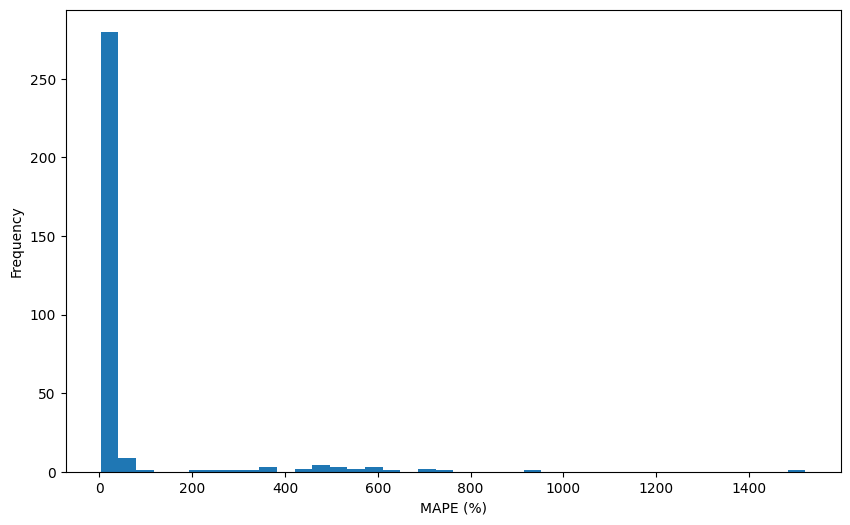

In [14]:
# plot a histogram of the MAPE results
plt.figure(figsize=(10, 6))
plt.hist(mape_results_clean, bins=40)
plt.xlabel('MAPE (%)')
plt.ylabel('Frequency')
plt.show()

### Analysis of the results: high MAPE vs low MAPE

In [28]:
high_mapes = {k: v for k,v in mape_results_clean.items() if v > 1}
low_mapes = {k: v for k,v in mape_results_clean.items() if v <= 1}
print(np.mean(list(low_mapes.values())))

0.12249674054040516


In [26]:
print(high_mapes)

{'EC_2': 5.473703896556939, 'EC_22': 2.6881593187611985, 'EC_56': 5.18163857045811, 'EC_63': 3.1328077441209827, 'EC_89': 2.1720556278000145, 'EC_92': 4.336642888963429, 'EC_122': 3.7534324929356453, 'EC_135': 9.180197671342802, 'EC_142': 7.504817432496499, 'EC_150': 5.498082944409341, 'EC_173': 5.123349170642898, 'EC_174': 6.282497048321514, 'EC_187': 5.06074397187785, 'EC_202': 1.0967114512468572, 'EC_204': 4.748623394540239, 'EC_228': 2.76720727863854, 'EC_235': 4.533423755919472, 'EC_245': 5.8760106889419905, 'EC_266': 6.016791644190387, 'EC_278': 4.5889523213058565, 'EC_281': 3.7078367735609508, 'EC_312': 4.590427670321957, 'EC_332': 6.870564644396602, 'EC_333': 15.212479334400381, 'EC_334': 4.886181800945548, 'EC_335': 6.99835188260977, 'EC_337': 5.815063023391987, 'EC_345': 3.6956777416767643}


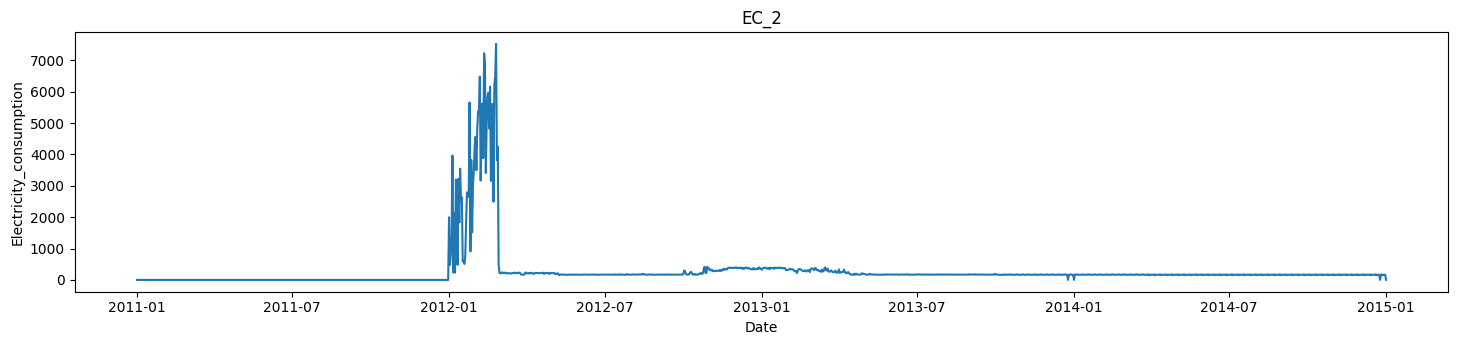

MAPE: 547.3704%


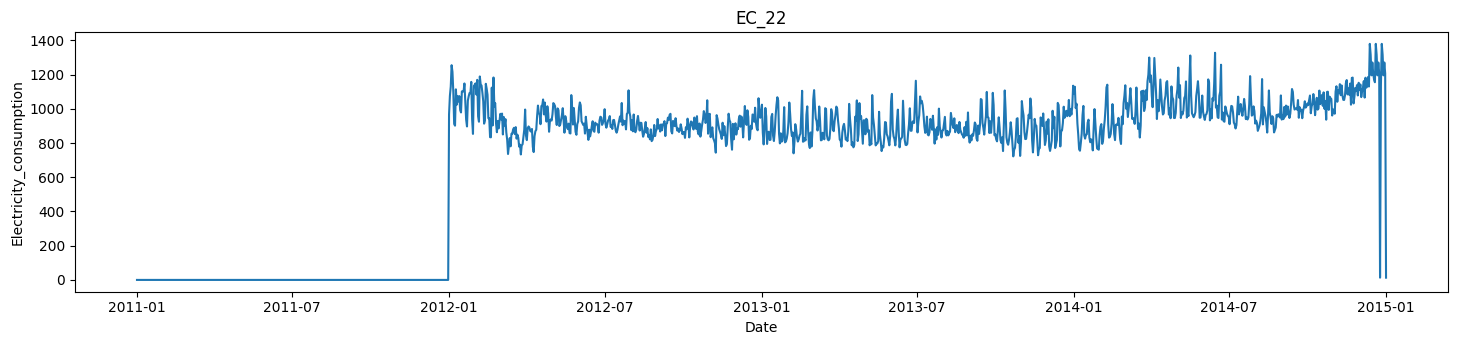

MAPE: 268.8159%


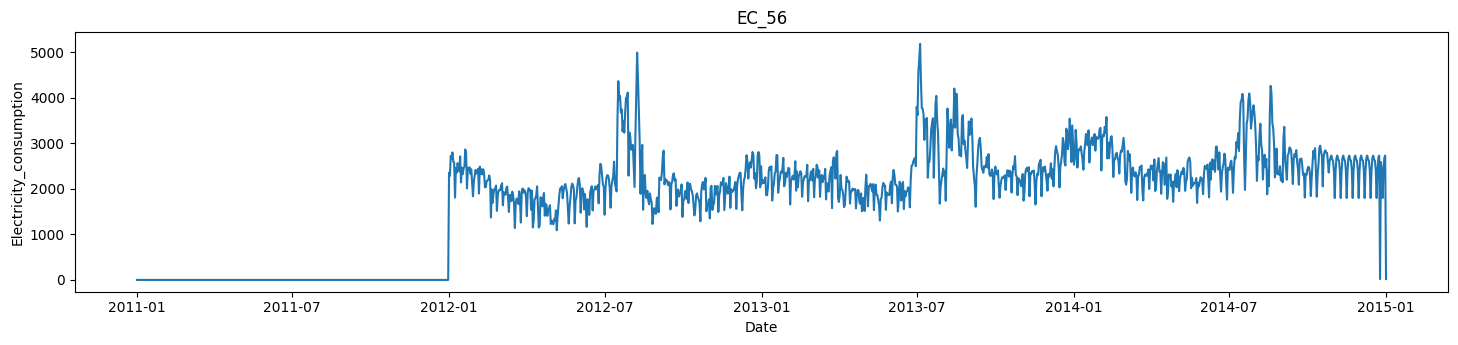

MAPE: 518.1639%


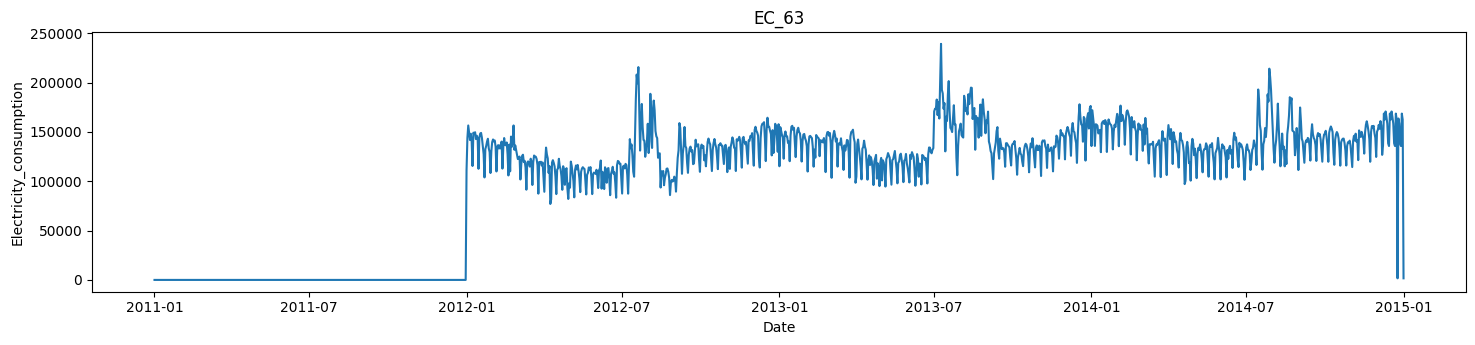

MAPE: 313.2808%


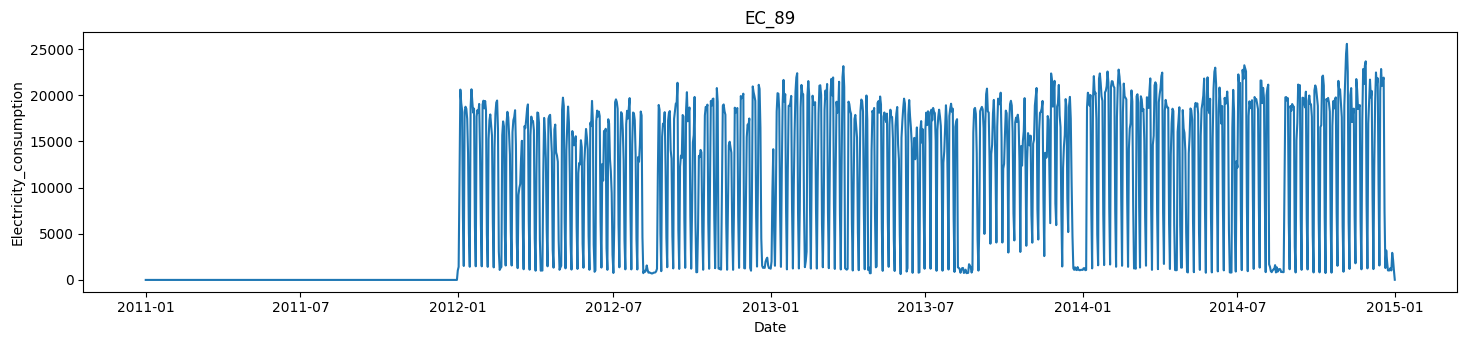

MAPE: 217.2056%


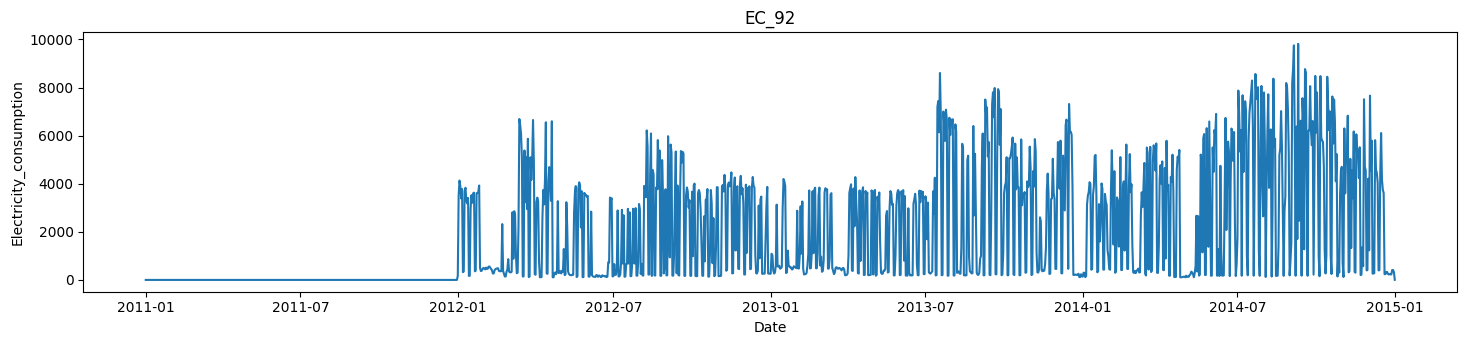

MAPE: 433.6643%


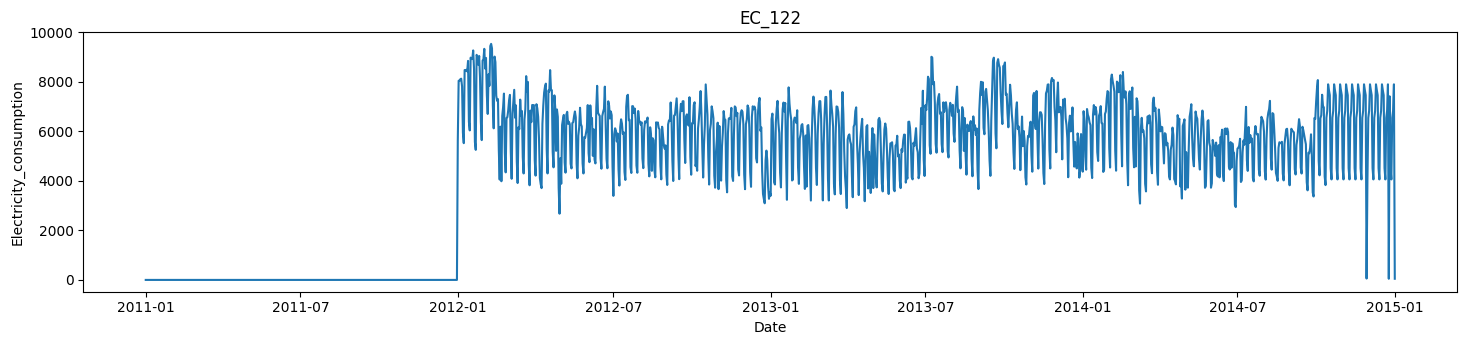

MAPE: 375.3432%


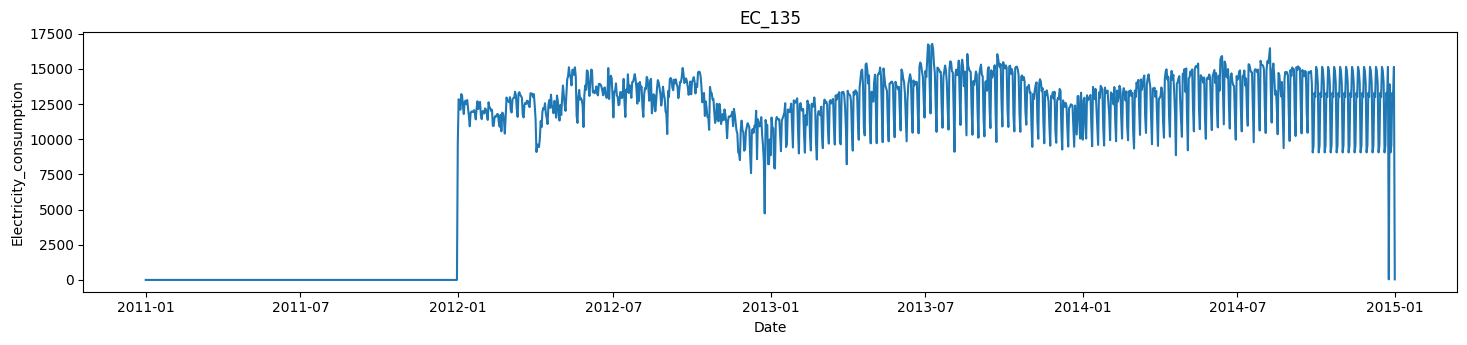

MAPE: 918.0198%


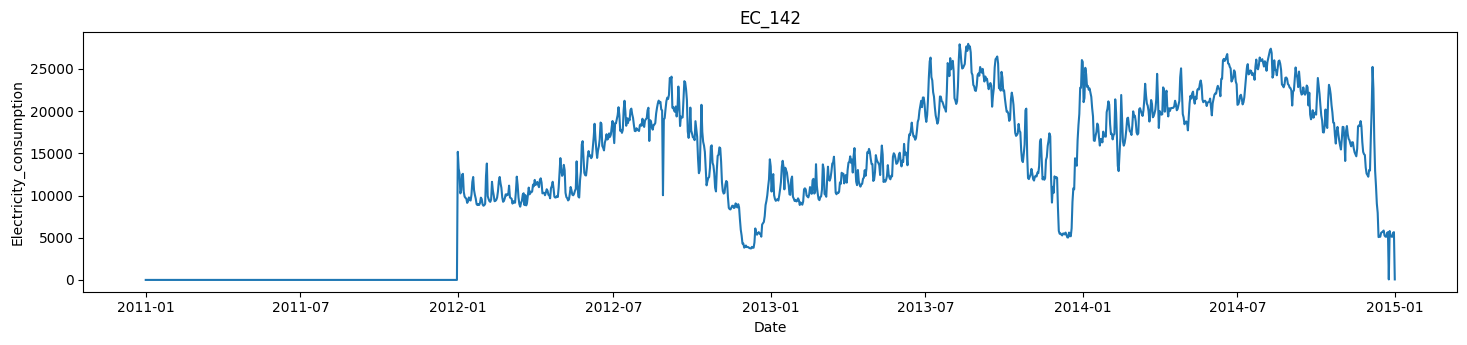

MAPE: 750.4817%


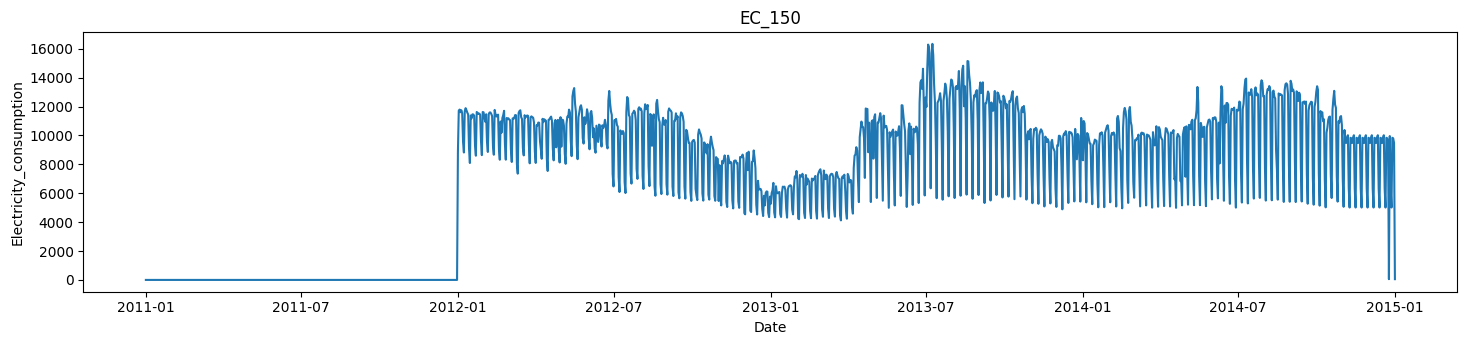

MAPE: 549.8083%


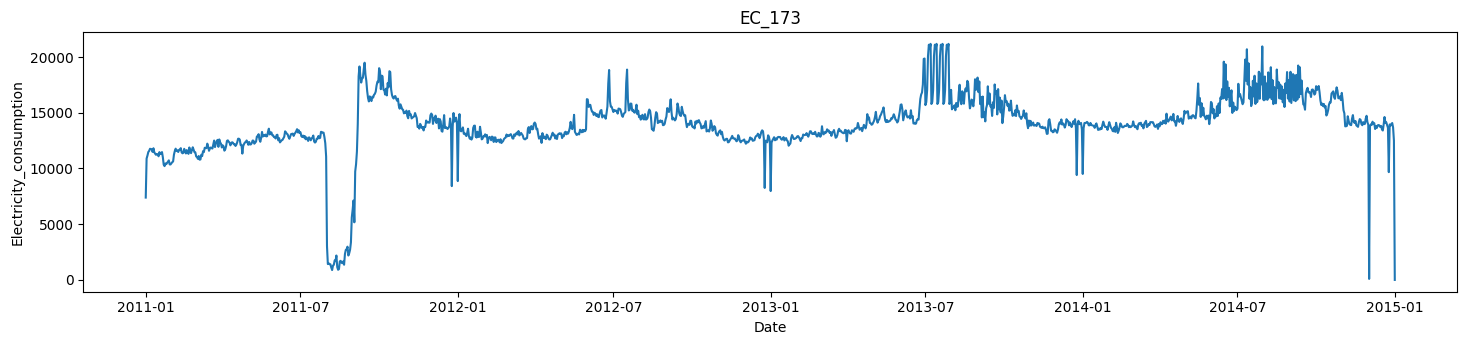

MAPE: 512.3349%


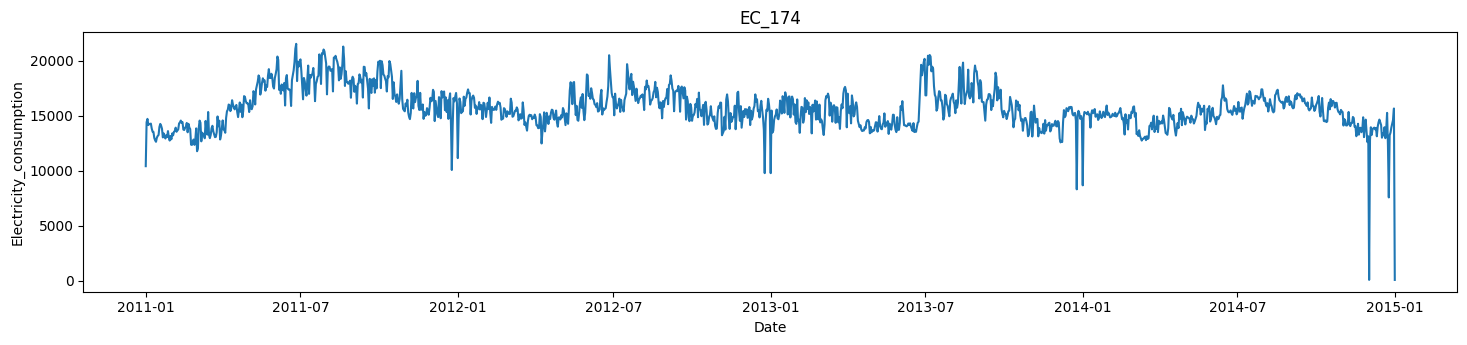

MAPE: 628.2497%


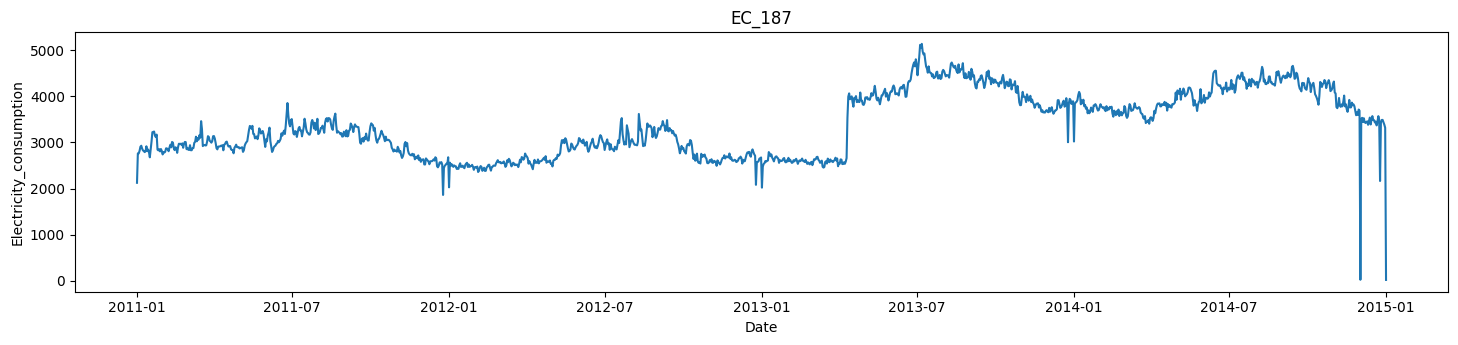

MAPE: 506.0744%


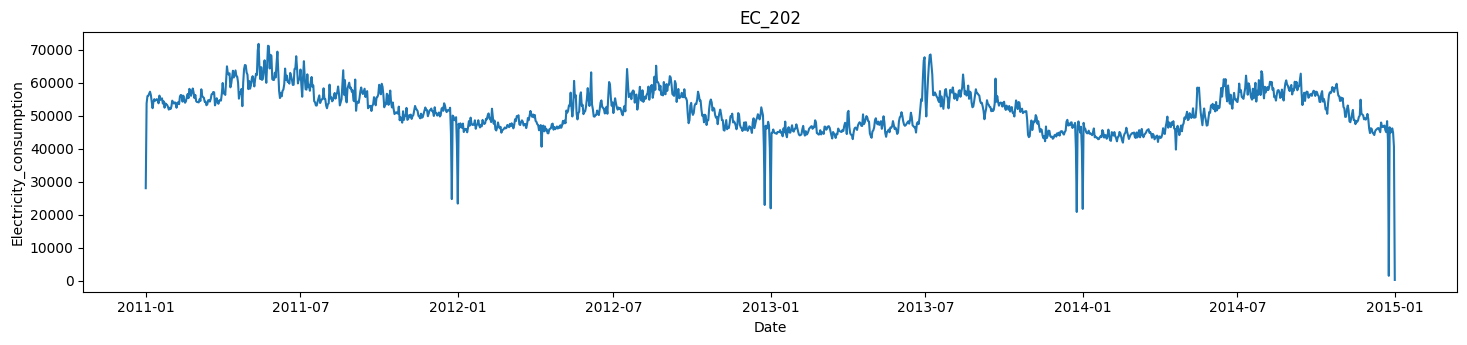

MAPE: 109.6711%


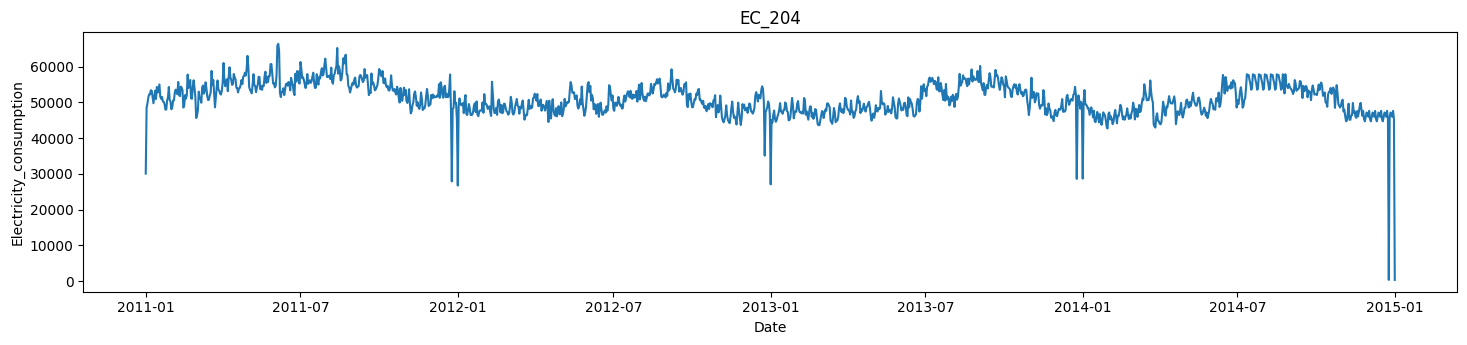

MAPE: 474.8623%


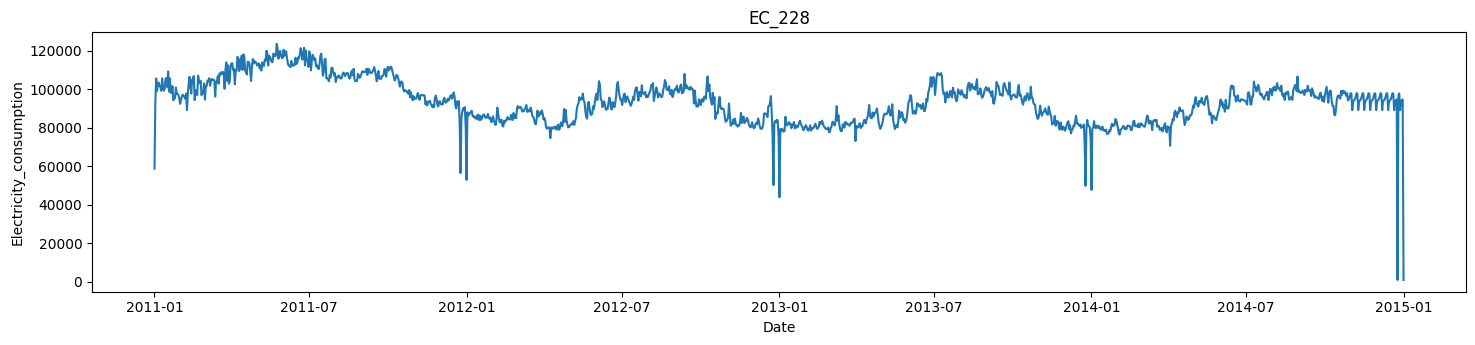

MAPE: 276.7207%


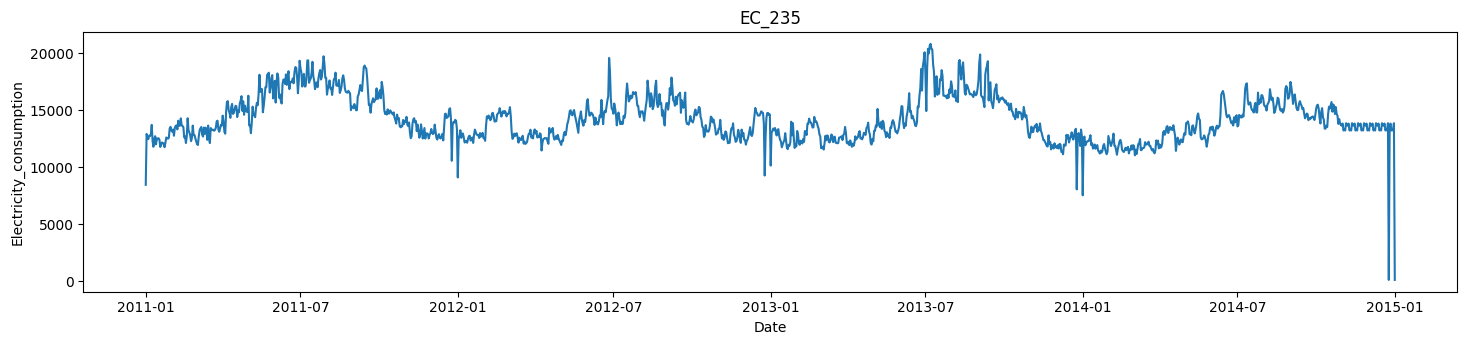

MAPE: 453.3424%


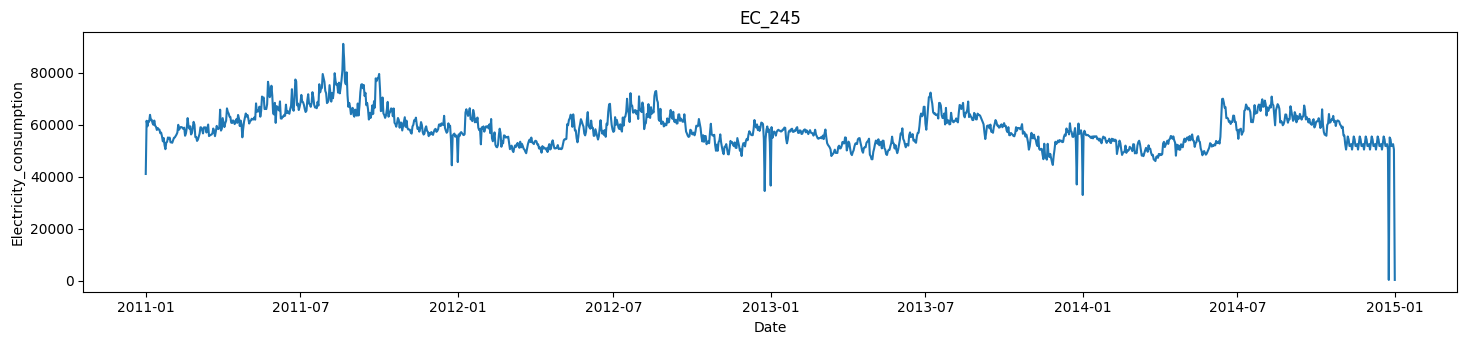

MAPE: 587.6011%


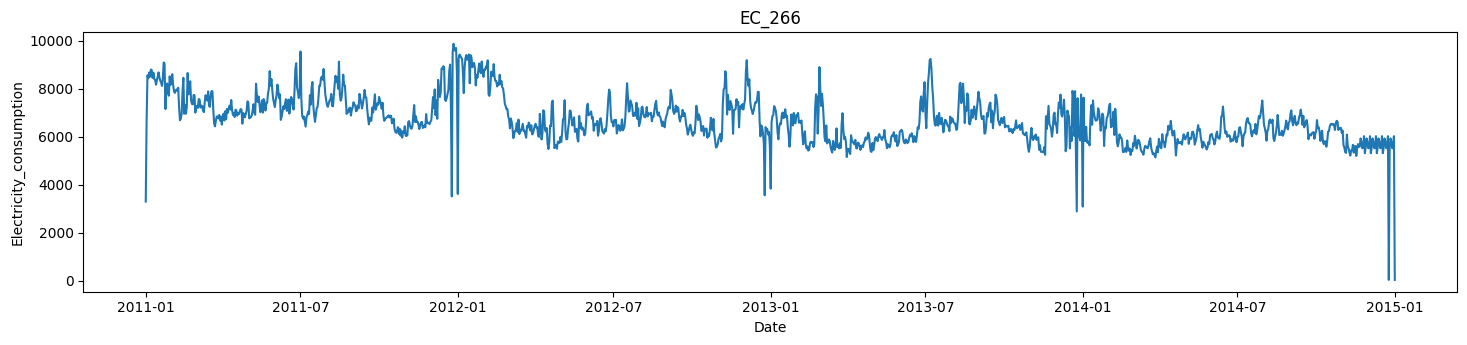

MAPE: 601.6792%


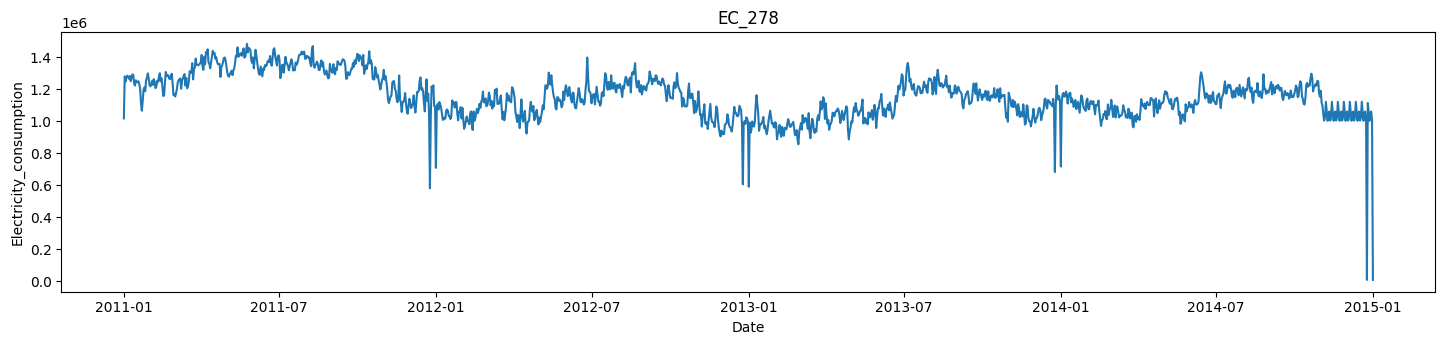

MAPE: 458.8952%


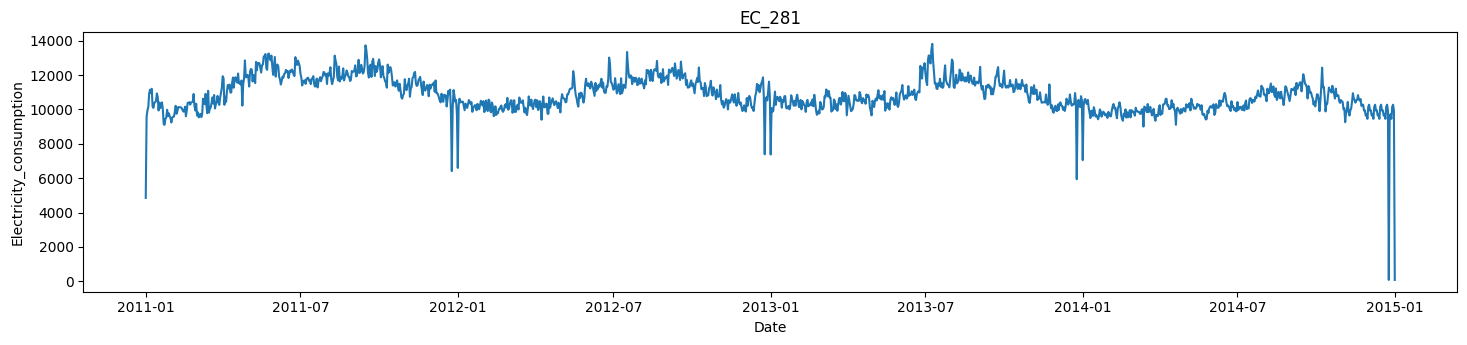

MAPE: 370.7837%


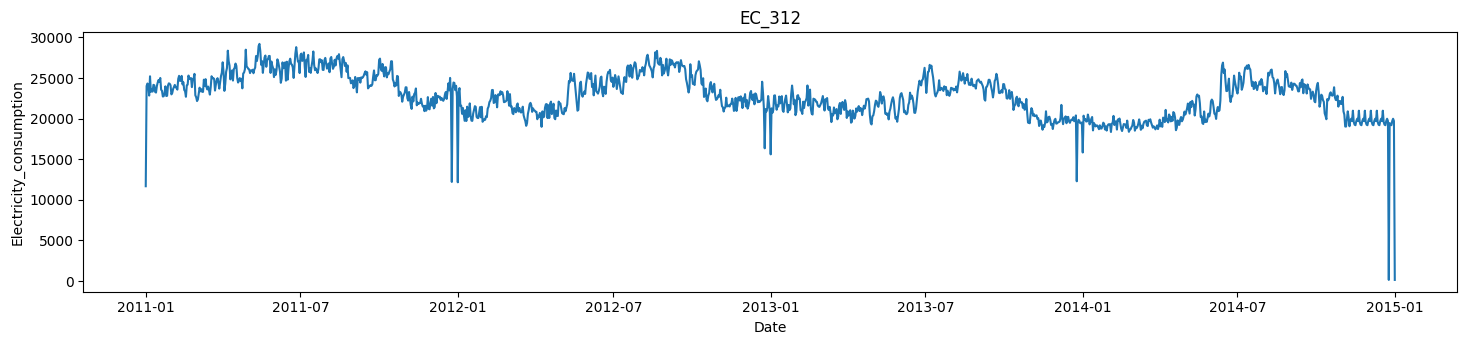

MAPE: 459.0428%


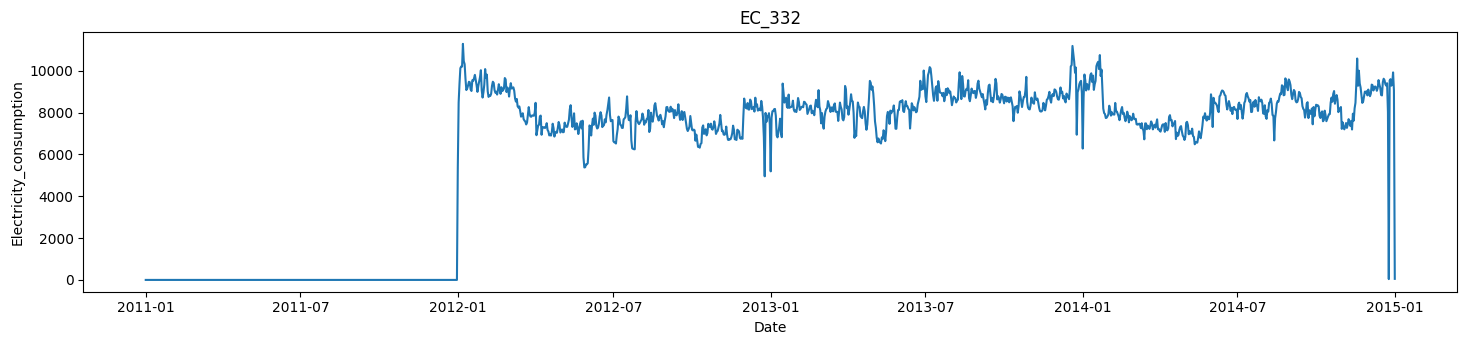

MAPE: 687.0565%


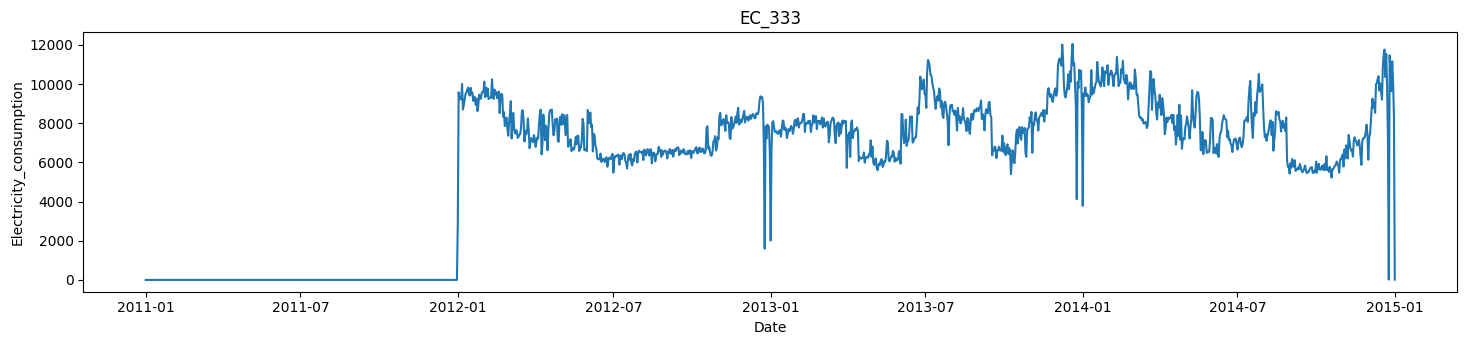

MAPE: 1521.2479%


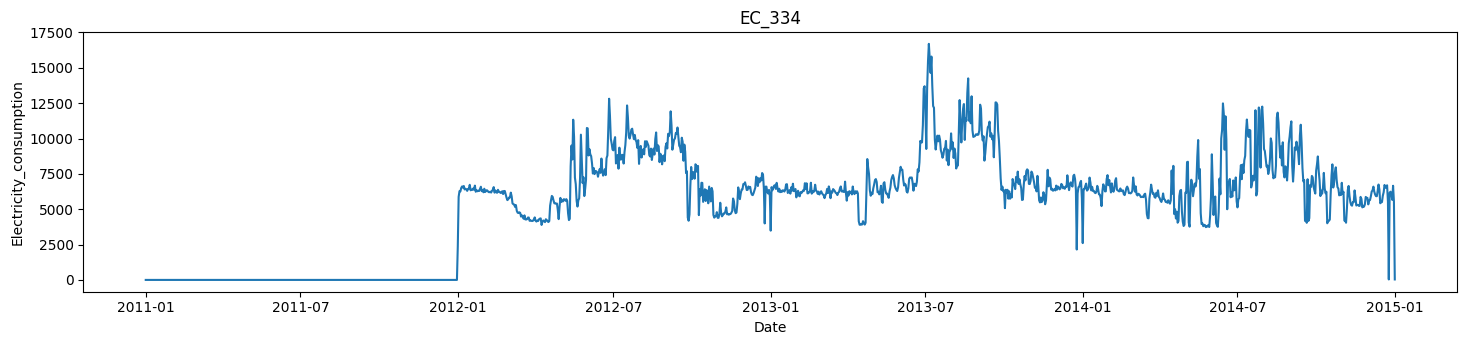

MAPE: 488.6182%


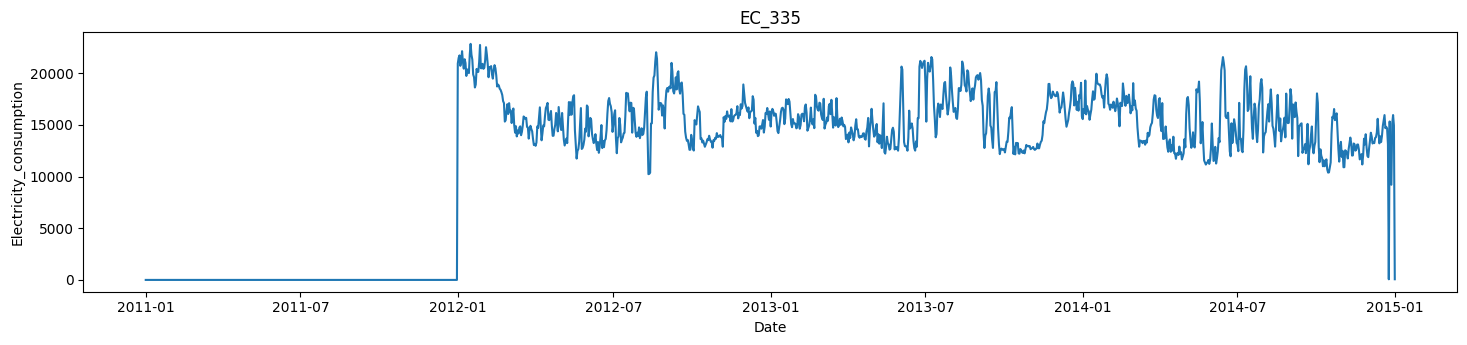

MAPE: 699.8352%


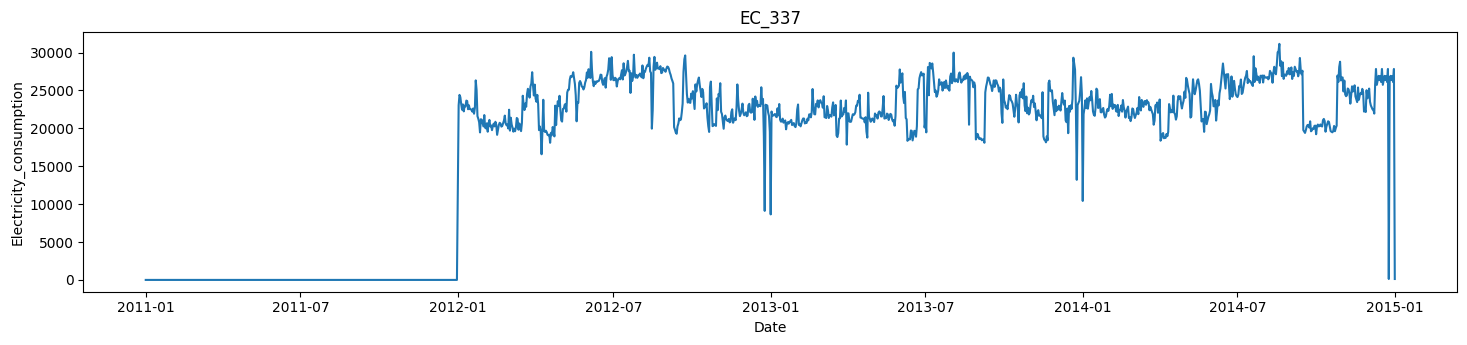

MAPE: 581.5063%


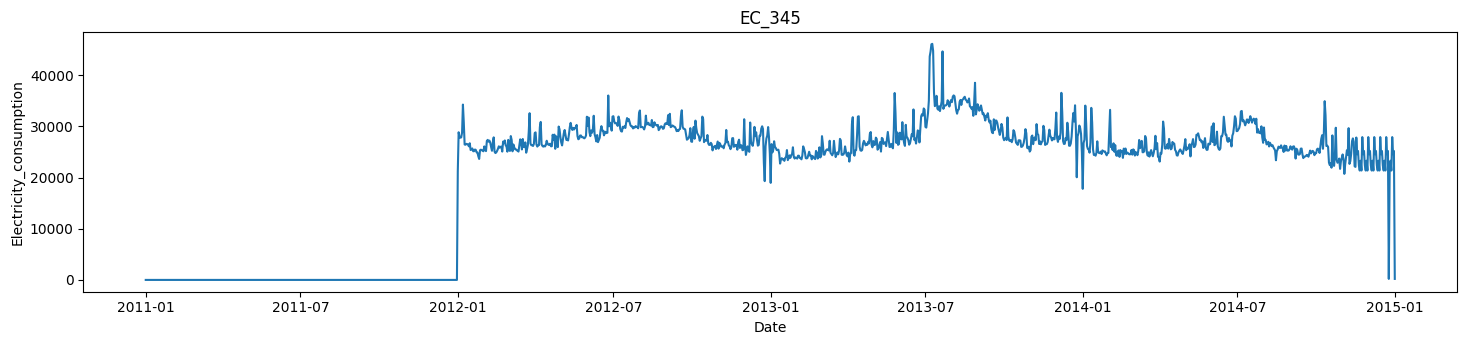

MAPE: 369.5678%


In [27]:
# plot the time series with a mape greater than 60%

for i in high_mapes.keys():
    plot_data(full_df, i)
    print("MAPE: {:.4%}".format(high_mapes[i]))

### Plotting the predictons for the best and worst time series

In [32]:
best_pred = float('inf')
for k in low_mapes.keys():
    if low_mapes[k] < best_pred:
        best_pred = low_mapes[k]
        best_index = k

print(best_index)

EC_160


19:55:38 - cmdstanpy - INFO - Chain [1] start processing
19:55:39 - cmdstanpy - INFO - Chain [1] done processing


The MAPE is 3.3495%


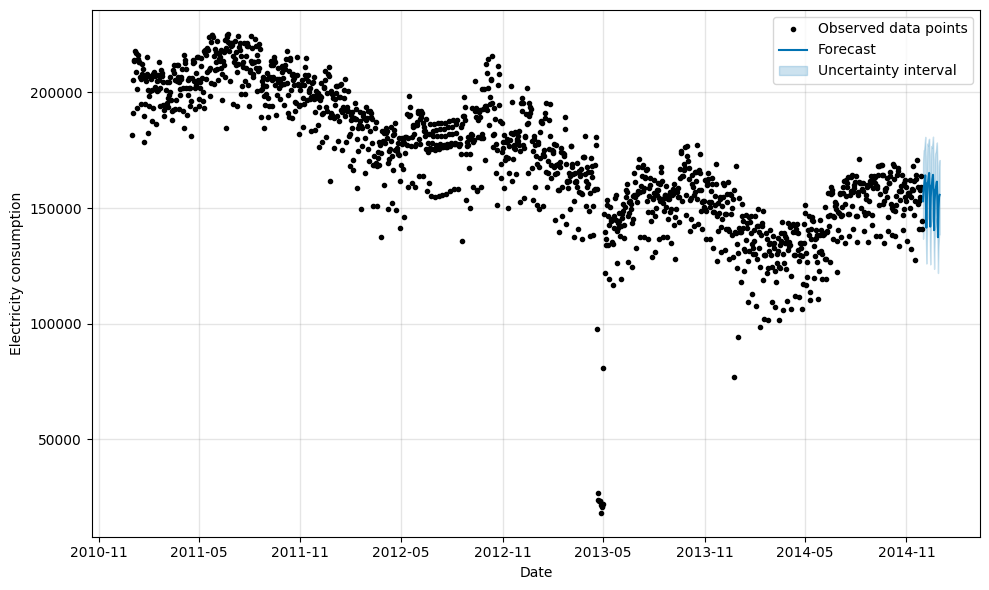

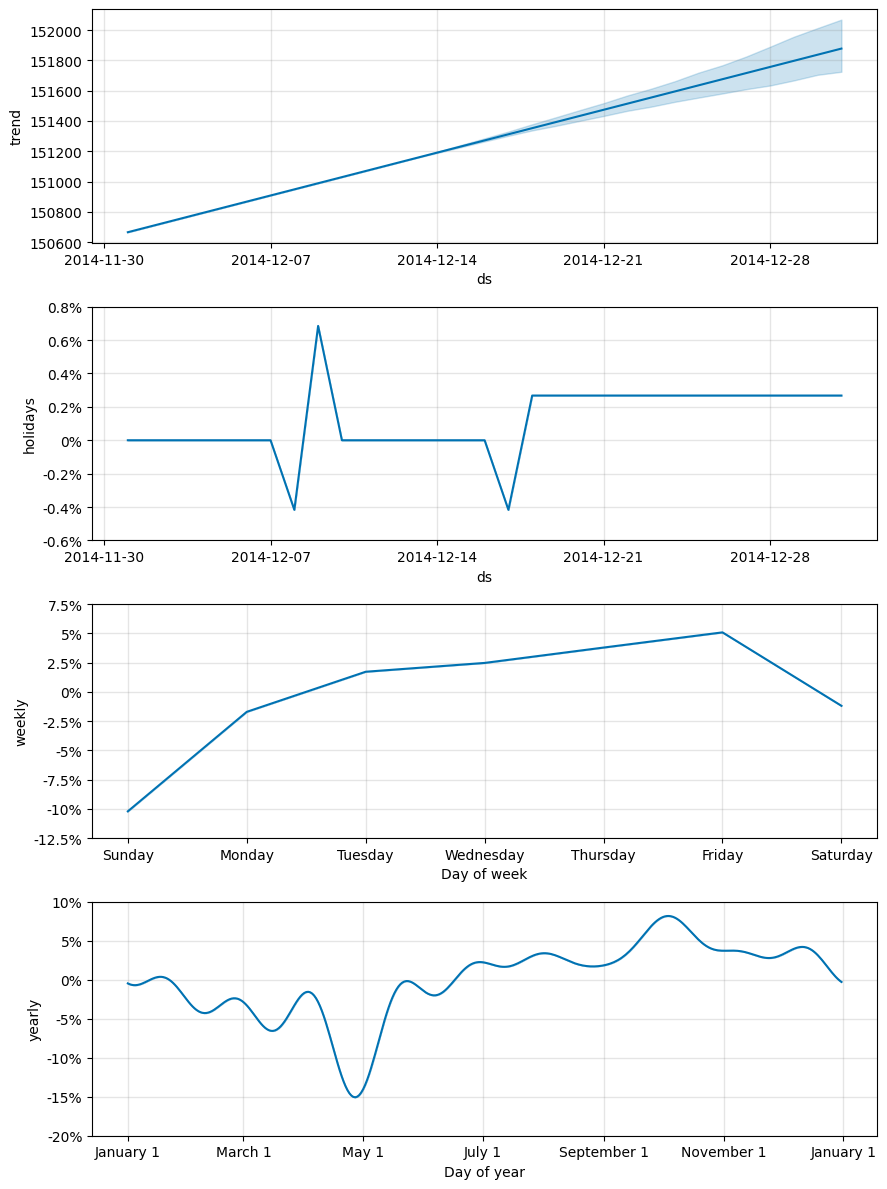

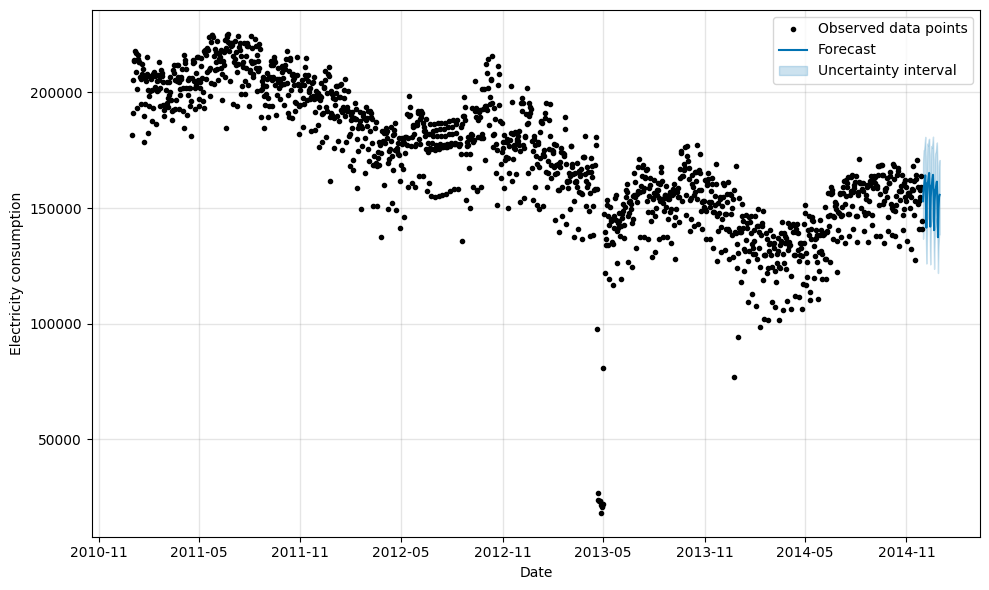

In [35]:
best_col = best_index # EC_160

df = full_df[[best_col]].copy()
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

model = Prophet(**best_params)
model.fit(train_df)

future = test_df[['ds']]
forecast = model.predict(future)

print("The MAPE is {:.4%}".format(calculate_mape(test_df['y'], forecast['yhat'])))

model.plot_components(forecast)
model.plot(forecast[-100:], xlabel='Date', ylabel='Electricity consumption', include_legend=True)

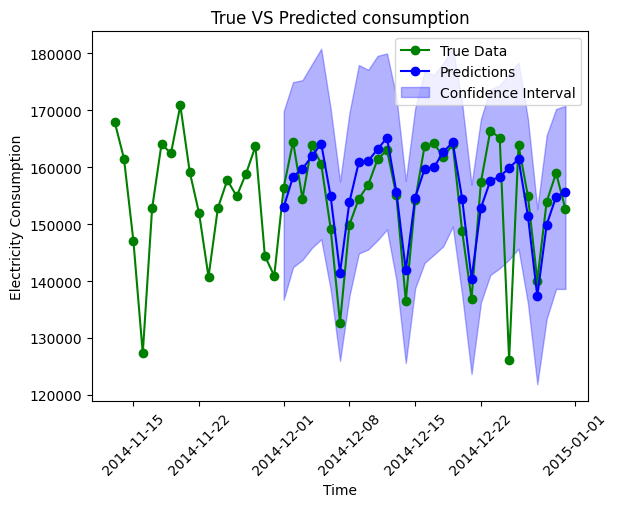

In [44]:
# Example data (replace with your actual data)
true_data = df['y'][-50:-1]
xtrue_data = df['ds'][-50:-1]
predictions = forecast['yhat'][-100:]
confidence_interval_low = forecast['yhat_lower'][-100:]
confidence_interval_high = forecast['yhat_upper'][-100:]

# Create an array for x-axis (e.g., time or index)
x = test_df['ds'][-100:]

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the true data
ax.plot(xtrue_data, true_data, label='True Data', marker='o', color='green')

# Plot your predictions
ax.plot(x, predictions, label='Predictions', marker='o', color='blue')

# Fill the area between the confidence intervals
ax.fill_between(x, confidence_interval_low, confidence_interval_high, alpha=0.3, color='blue', label='Confidence Interval')

plt.xticks(rotation=45)

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Electricity Consumption')
ax.set_title('True VS Predicted consumption')
ax.legend()

# Show the plot
plt.show()


EC_333


08:48:25 - cmdstanpy - INFO - Chain [1] start processing
08:48:26 - cmdstanpy - INFO - Chain [1] done processing


The MAPE is 1521.2479%


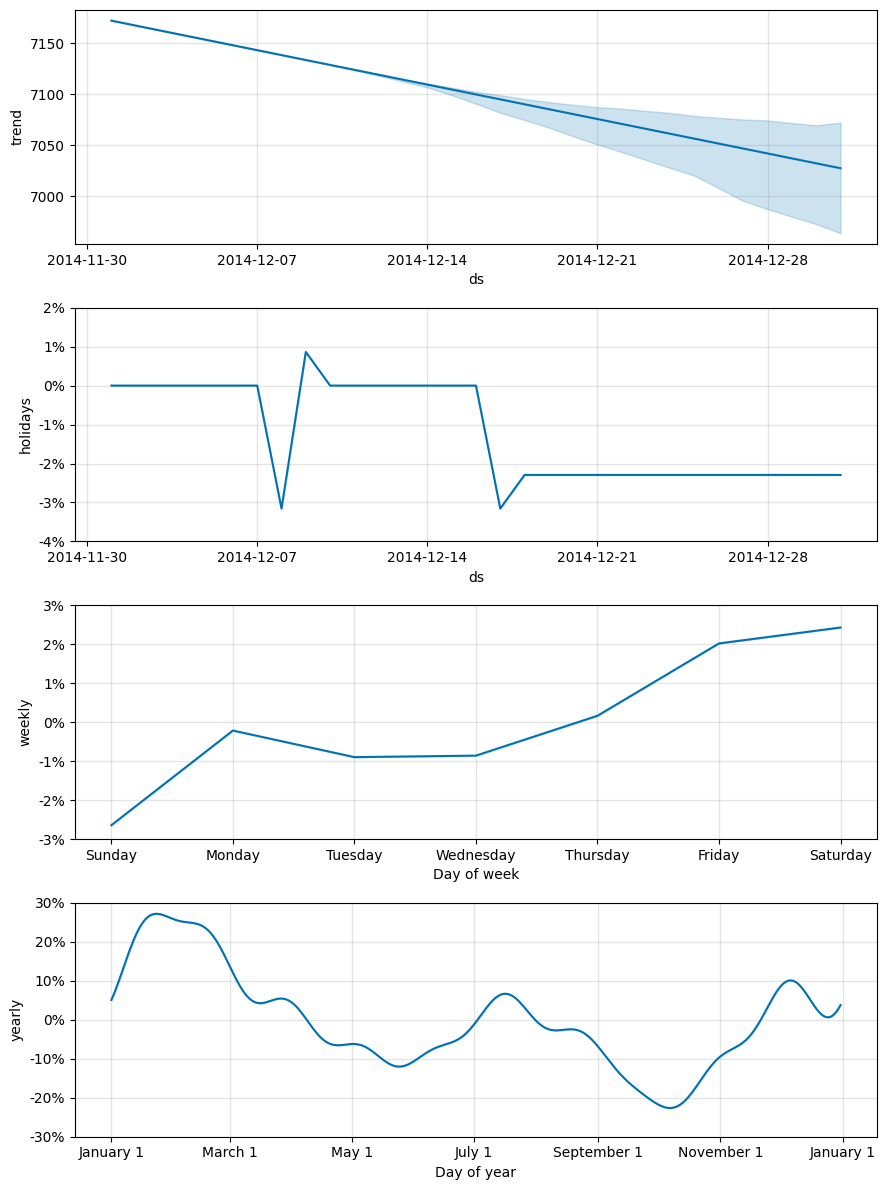

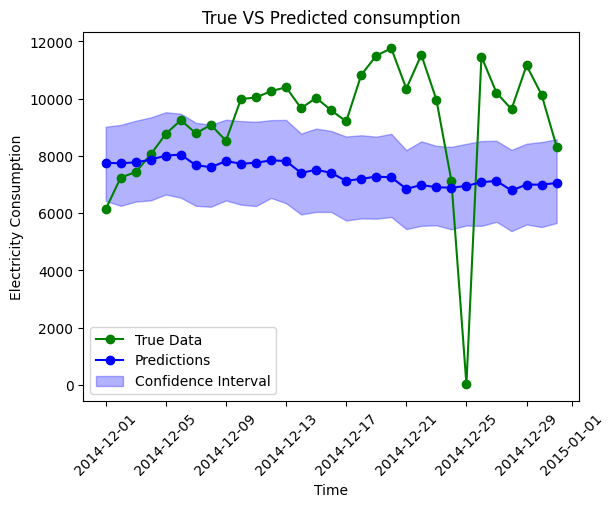

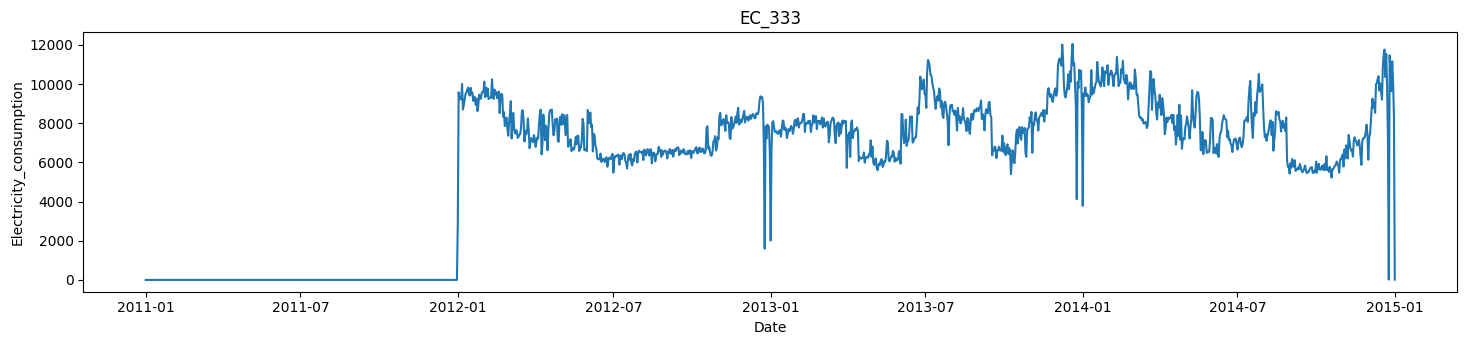

In [47]:
worse_pred = 0
for k in high_mapes.keys():
    if high_mapes[k] > worse_pred:
        worse_pred = high_mapes[k]
        worse_index = k

print(worse_index)

df = full_df[[worse_index]].copy()
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
train_df = df[:-test_size-1]
test_df = df[-test_size-1:-1]

model = Prophet(**best_params)
model.fit(train_df)

future = test_df[['ds']]
forecast = model.predict(future)

print("The MAPE is {:.4%}".format(calculate_mape(test_df['y'], forecast['yhat'])))
model.plot_components(forecast)

# Example data (replace with your actual data)
true_data = df['y'][-test_size-1:-1]
xtrue_data = df['ds'][-test_size-1:-1]
predictions = forecast['yhat'][-100:]
confidence_interval_low = forecast['yhat_lower'][-100:]
confidence_interval_high = forecast['yhat_upper'][-100:]

# Create an array for x-axis (e.g., time or index)
x = test_df['ds'][-100:]

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the true data
ax.plot(xtrue_data, true_data, label='True Data', marker='o', color='green')

# Plot your predictions
ax.plot(x, predictions, label='Predictions', marker='o', color='blue')

# Fill the area between the confidence intervals
ax.fill_between(x, confidence_interval_low, confidence_interval_high, alpha=0.3, color='blue', label='Confidence Interval')

plt.xticks(rotation=45)

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Electricity Consumption')
ax.set_title('True VS Predicted consumption')
ax.legend()

# Show the plot
plt.show()

plot_data(full_df, worse_index)